In [1]:
cd lag-llama

D:\jupyter\lag-llama-git\lag-llama


In [2]:
#pip install -r requirements.txt

In [3]:
#!pip install pandas==2.0.3
#!pip install gluonts==0.14.4

In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir .

lag-llama.ckpt


In [5]:
from gluonts.torch import TemporalFusionTransformerEstimator, DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from sklearn.model_selection import train_test_split
from gluonts.dataset.pandas import PandasDataset
from tqdm.autonotebook import tqdm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from itertools import islice
import pandas as pd
import warnings
import torch

In [6]:
warnings.simplefilter("ignore", UserWarning)

In [7]:
dataset = pd.read_csv('../Top_Dataset/scraping/top_18_stock.csv', index_col=0, parse_dates=True)
dataset = dataset.iloc[:, [0]]

In [8]:
dataset

BBCA
2020-02-03  32200
2020-02-04  33000
2020-02-05  33650
2020-02-06  33700
2020-02-07  33800
...           ...
2024-06-03   9275
2024-06-04   9350
2024-06-05   9450
2024-06-06   9475
2024-06-07   9325

[1135 rows x 1 columns]

In [9]:
len(dataset)

1135

In [10]:
#total_data = len(dataset )
#train      = int(0.7 * total_data)
#test       = total_data - train_data

#train_data = data.iloc[:train]
#test_data  = data.iloc[test:]

# Splitting data training (70%), testing data (30%).
train_data, test_data = train_test_split(dataset, test_size=0.3, shuffle=False)

print("Train data:", len(train_data))
print("Test data:", len(test_data))

Train data: 794
Test data: 341


In [11]:
freq_1 = pd.infer_freq(train_data.index)
freq_2 = pd.infer_freq(test_data.index)

print(f"frequency used train data: {freq_1}")
print(f"frequency used test data: {freq_2}")

frequency used train data: B
frequency used test data: B


In [12]:
prediction_length =32
num_samples=20
batch_size=64
epoch=50

# **Function**

In [13]:
def preprocess_dataset(data):
    for col in data.columns:
        if data[col].dtype != 'object' and not pd.api.types.is_string_dtype(data[col]):
            data[col] = data[col].astype('float32')
    return PandasDataset(dict(data))

backtrain_dataset = preprocess_dataset(train_data)
backtest_dataset  = preprocess_dataset(test_data)

### Function Lag-Llama Zero-Shot

In [14]:
def lag_llama_zero_shot(context_length, use_rope_scaling):
    
    ckpt = torch.load("lag-llama.ckpt", map_location="cuda")
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        batch_size=batch_size,
        num_parallel_samples=num_samples
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_zero_shot_it, ts_zero_shot_it = make_evaluation_predictions(
        dataset=backtest_dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    zero_shot_forecasts = list(forecast_zero_shot_it)
    zero_shot_tss = list(ts_zero_shot_it)

    evaluator = Evaluator()
    agg_metrics, ts_metrics = evaluator(iter(zero_shot_tss), iter(zero_shot_forecasts))

    return zero_shot_forecasts, zero_shot_tss, agg_metrics

In [15]:
def print_crps_zero_shot(context_length, use_rope_scaling, agg_metrics):
    crps = agg_metrics['mean_wQuantileLoss']
    print(f"Lag-Llama Zero-Shot ({context_length}) rope_scaled ({use_rope_scaling}) CRPS: {crps:.4f}")
    return crps

### Function Lag-Llama Fine-Tuning

In [16]:
def lag_llama_fine_tuning(context_length, lr):
    ckpt = torch.load("lag-llama.ckpt", map_location="cuda")
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        nonnegative_pred_samples=True,
        
        aug_prob=0,
        lr=lr,
        
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],
        
        batch_size=batch_size,
        num_parallel_samples=num_samples,
        trainer_kwargs={"max_epochs": epoch},
    )

    predictor = estimator.train(
        backtrain_dataset,
        cache_data=True,
        shuffle_buffer_length=1000
    )

    fine_tuning_forecast_it, fine_tuning_ts_it = make_evaluation_predictions(
        dataset=backtest_dataset,
        predictor=predictor,
        num_samples=num_samples
    )

    fine_tuning_forecasts = list(fine_tuning_forecast_it)
    fine_tuning_tss = list(fine_tuning_ts_it)

    evaluator = Evaluator()
    agg_metrics, ts_metrics = evaluator(iter(fine_tuning_tss), iter(fine_tuning_forecasts))

    return fine_tuning_forecasts, fine_tuning_tss, agg_metrics

In [17]:
def print_crps_fine_tuning(context_length, lr, agg_metrics):
    crps = agg_metrics['mean_wQuantileLoss']
    print(f"Lag-Llama Fine-Tuning ({context_length}) Lr {lr} CRPS: {crps:.4f}")
    return crps

### Function Plotting

In [18]:
def plotting(forecasts, tss):
    plt.figure(figsize=(20, 15))
    date_formatter = mdates.DateFormatter('%d-%m-%Y')
    plt.rcParams.update({'font.size': 15})

    for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
        ax = plt.subplot(3, 3, idx+1)
        plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target")
        forecast.plot(color='g')
        plt.xticks(rotation=60)
        ax.xaxis.set_major_formatter(date_formatter)
        ax.set_title(forecast.item_id)

    plt.gcf().tight_layout()
    plt.legend()
    plt.show()

# **Lag-Llama Zero-Shot**

## Zero-Shot Forecasting: Tuning the context length

### Get predictions with the default context length ***(32)***

In [19]:
forecasts_zero_shot_len_32_false, tss_zero_shot_len_32_false, agg_metrics = lag_llama_zero_shot(32, False)
zero_shot_len_32_false = print_crps_zero_shot(32, False, agg_metrics)

Running evaluation: 1it [00:00, 199.53it/s]

Lag-Llama Zero-Shot (32) rope_scaled (False) CRPS: 0.0313


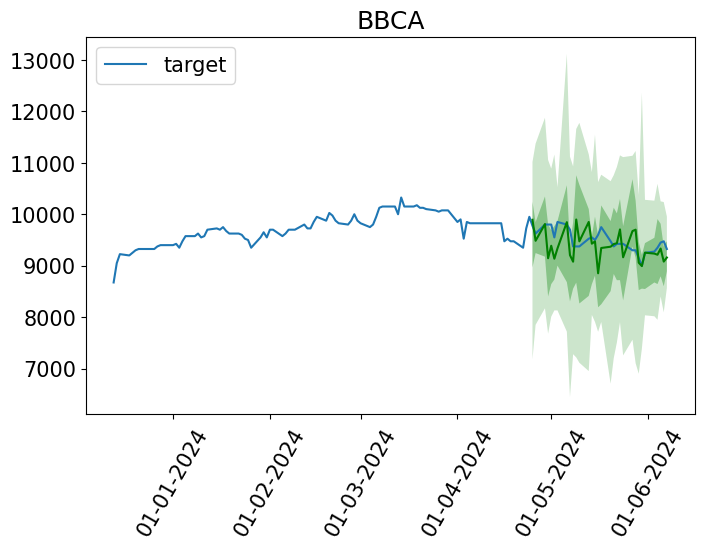

In [20]:
plotting(forecasts_zero_shot_len_32_false, tss_zero_shot_len_32_false)

### Get predictions with the default context length ***(64)***

In [21]:
forecasts_zero_shot_len_64_false, tss_zero_shot_len_64_false, agg_metrics = lag_llama_zero_shot(64, False)
zero_shot_len_64_false = print_crps_zero_shot(64, False, agg_metrics)

Running evaluation: 1it [00:00, 199.87it/s]

Lag-Llama Zero-Shot (64) rope_scaled (False) CRPS: 0.0383


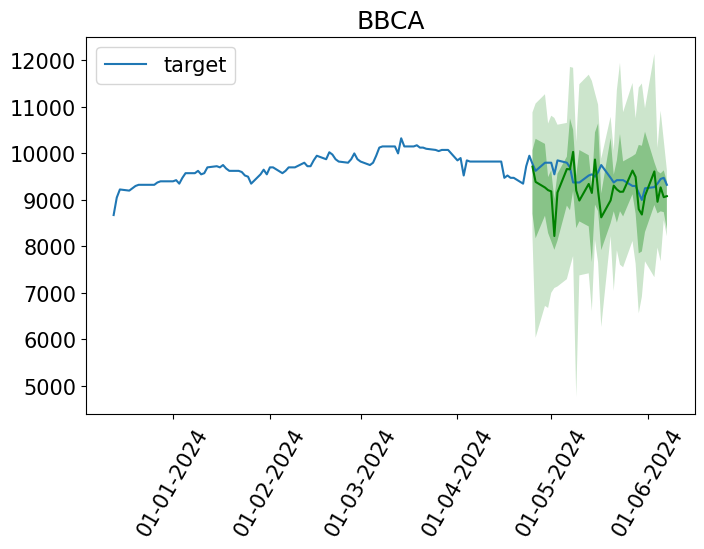

In [22]:
plotting(forecasts_zero_shot_len_64_false, tss_zero_shot_len_64_false)

Now enable **RoPE scaling** which better equips the model in handling large context lengths (larger than 32 in this case). This is done by passing `use_rope_scaling=True` to the `get_lag_llama_predictions` function.

In [23]:
forecasts_zero_shot_len_64_true, tss_zero_shot_len_64_true, agg_metrics = lag_llama_zero_shot(64, True)
zero_shot_len_64_true = print_crps_zero_shot(64, True, agg_metrics)

Running evaluation: 1it [00:00, 199.04it/s]

Lag-Llama Zero-Shot (64) rope_scaled (True) CRPS: 0.0365


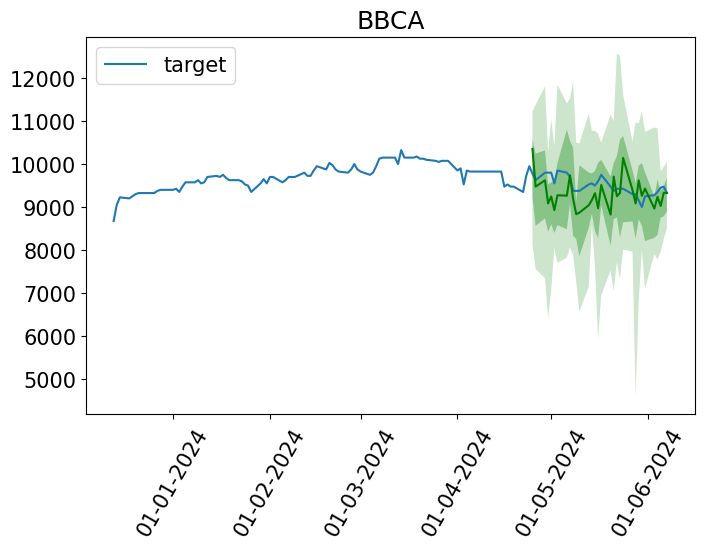

In [24]:
plotting(forecasts_zero_shot_len_64_true, tss_zero_shot_len_64_true)

### Get predictions with the default context length ***(128)***

In [25]:
forecasts_zero_shot_len_128_true, tss_zero_shot_len_128_true, agg_metrics = lag_llama_zero_shot(128, True)
zero_shot_len_128_true = print_crps_zero_shot(128, True, agg_metrics)

Running evaluation: 1it [00:00, 166.20it/s]

Lag-Llama Zero-Shot (128) rope_scaled (True) CRPS: 0.0374


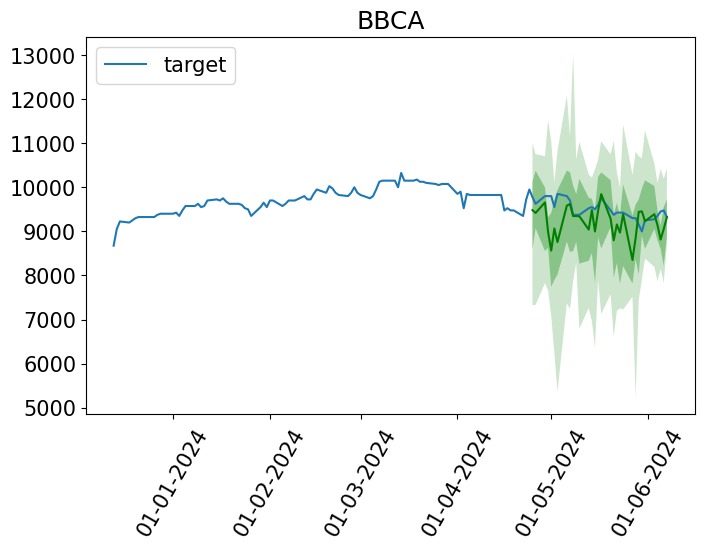

In [26]:
plotting(forecasts_zero_shot_len_128_true, tss_zero_shot_len_128_true)

### Get predictions with the default context length ***(256)***

In [27]:
forecasts_zero_shot_len_256_true, tss_zero_shot_len_256_true, agg_metrics = lag_llama_zero_shot(256, True)
zero_shot_len_256_true = print_crps_zero_shot(256, True, agg_metrics)

Running evaluation: 1it [00:00, 199.75it/s]

Lag-Llama Zero-Shot (256) rope_scaled (True) CRPS: 0.0348


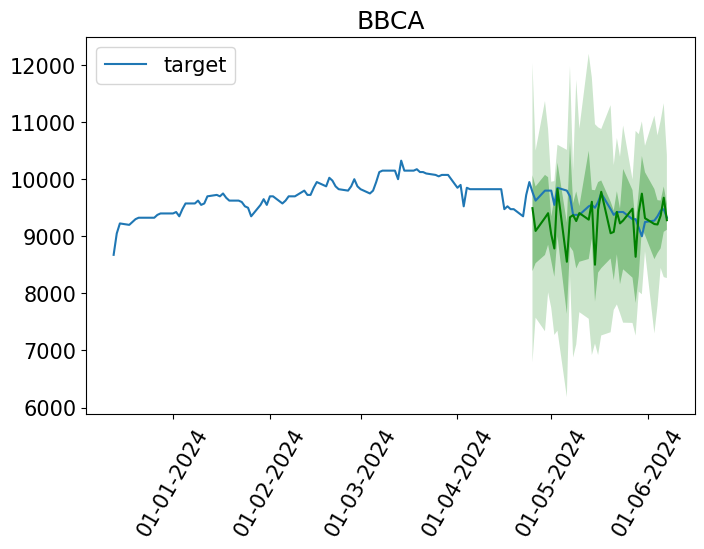

In [28]:
plotting(forecasts_zero_shot_len_256_true, tss_zero_shot_len_256_true)

### Get predictions with the default context length ***(512)***

In [29]:
forecasts_zero_shot_len_512_true, tss_zero_shot_len_512_true, agg_metrics = lag_llama_zero_shot(512, True)
zero_shot_len_512_true = print_crps_zero_shot(512, True, agg_metrics)

Running evaluation: 1it [00:00, 99.84it/s]

Lag-Llama Zero-Shot (512) rope_scaled (True) CRPS: 0.0459


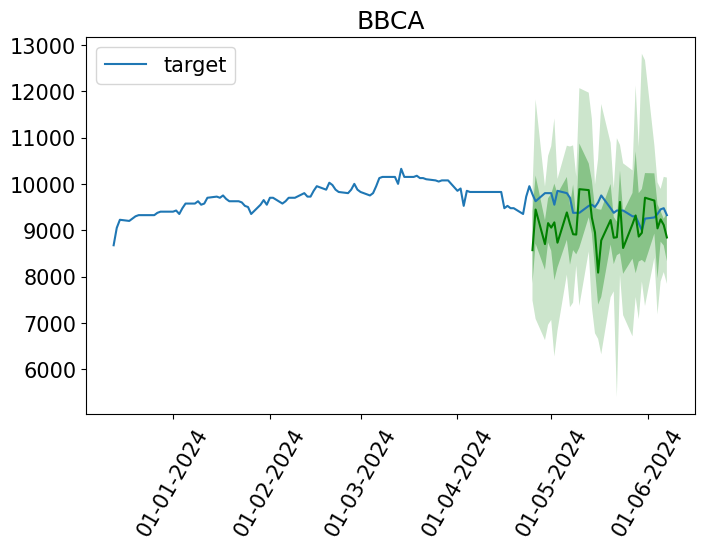

In [30]:
plotting(forecasts_zero_shot_len_512_true, tss_zero_shot_len_512_true)

### Get predictions with the default context length ***(1024)***

In [31]:
forecasts_zero_shot_len_1024_true, tss_zero_shot_len_1024_true, agg_metrics = lag_llama_zero_shot(1024, True)
zero_shot_len_1024_true = print_crps_zero_shot(1024, True, agg_metrics)

Running evaluation: 1it [00:00, 199.77it/s]

Lag-Llama Zero-Shot (1024) rope_scaled (True) CRPS: 0.0461


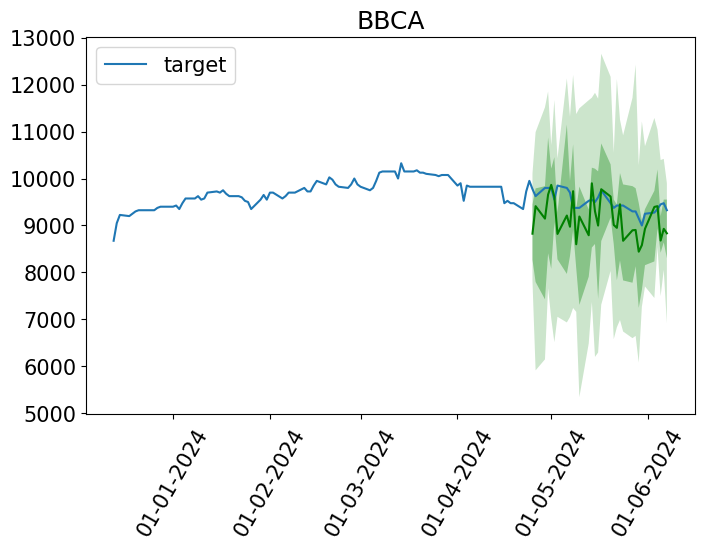

In [32]:
plotting(forecasts_zero_shot_len_1024_true, tss_zero_shot_len_1024_true)

# **Lag-Llama Fine-Tuning**

### ***Learning Rate 1e-2***

### Get predictions with the default context length ***(32)***

In [33]:
forecasts_fine_tuning_len_32_lr_1e_2, tss_fine_tuning_len_32_lr_1e_2, agg_metrics = lag_llama_fine_tuning(32, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 12.15662 (best 12.15662), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_377\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 10.90389 (best 10.90389), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_377\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 10.82496 (best 10.82496), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_377\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 10.49243 (best 10.49243), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_377\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 9.87130 (best 9.87130), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_377\\checkpoints\\epoch=4-step=250.ckpt

In [34]:
fine_tuning_len_32_lr_1e_2 = print_crps_fine_tuning(32, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.01 CRPS: 0.0182


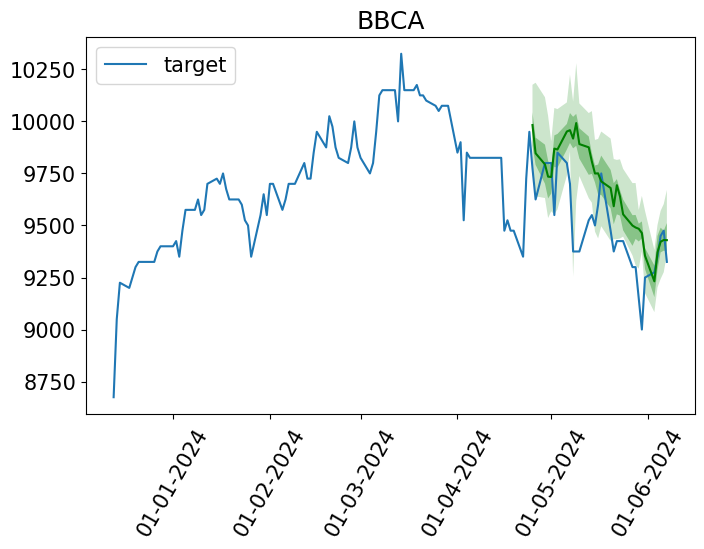

In [35]:
plotting(forecasts_fine_tuning_len_32_lr_1e_2, tss_fine_tuning_len_32_lr_1e_2)

### Get predictions with the default context length ***(64)***

In [36]:
forecasts_fine_tuning_len_64_lr_1e_2, tss_fine_tuning_len_64_lr_1e_2, agg_metrics = lag_llama_fine_tuning(64, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 11.39343 (best 11.39343), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_378\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' was not in top 1
Epoch 2, global step 150: 'train_loss' reached 10.70179 (best 10.70179), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_378\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 9.99321 (best 9.99321), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_378\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 9.92309 (best 9.92309), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_378\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 9.08937 (best 9.08937), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_l

In [37]:
fine_tuning_len_64_lr_1e_2 = print_crps_fine_tuning(64, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.01 CRPS: 0.0140


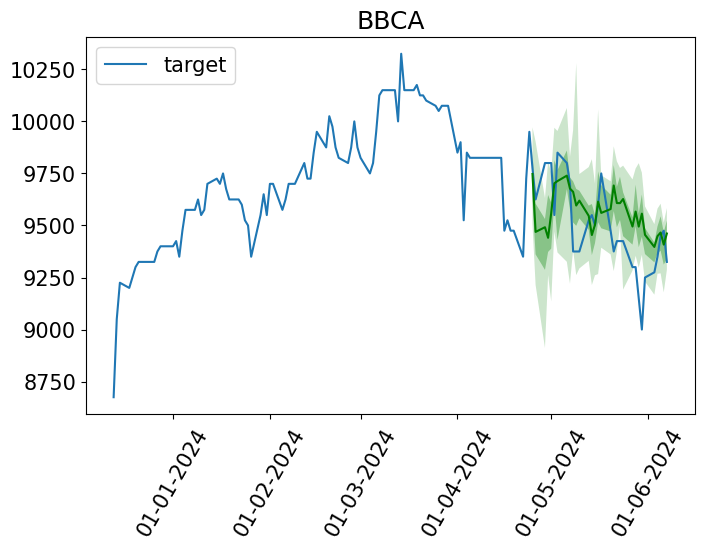

In [38]:
plotting(forecasts_fine_tuning_len_64_lr_1e_2, tss_fine_tuning_len_64_lr_1e_2)

### Get predictions with the default context length ***(128)***

In [39]:
forecasts_fine_tuning_len_128_lr_1e_2, tss_fine_tuning_len_128_lr_1e_2, agg_metrics = lag_llama_fine_tuning(128, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 12.05014 (best 12.05014), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_379\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 10.85696 (best 10.85696), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_379\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 10.61825 (best 10.61825), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_379\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 10.07173 (best 10.07173), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_379\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 9.66145 (best 9.66145), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightni

In [40]:
fine_tuning_len_128_lr_1e_2 = print_crps_fine_tuning(128, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.01 CRPS: 0.0599


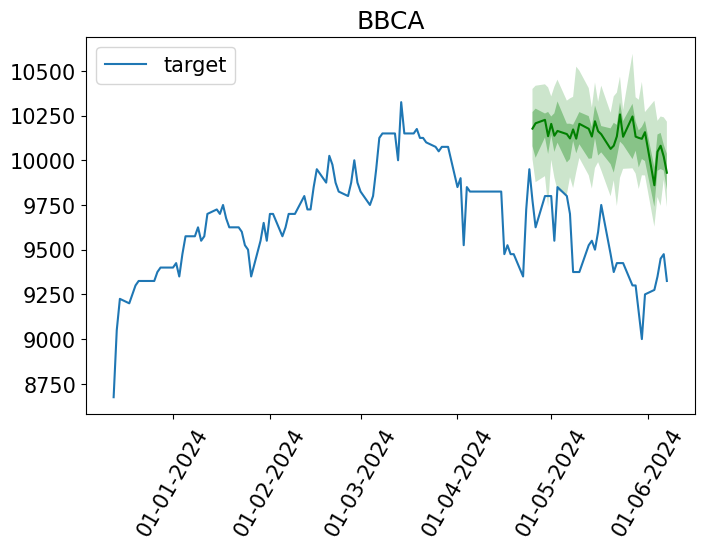

In [41]:
plotting(forecasts_fine_tuning_len_128_lr_1e_2, tss_fine_tuning_len_128_lr_1e_2)

### Get predictions with the default context length ***(256)***

In [42]:
forecasts_fine_tuning_len_256_lr_1e_2, tss_fine_tuning_len_256_lr_1e_2, agg_metrics = lag_llama_fine_tuning(256, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 12.06980 (best 12.06980), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_380\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 10.74551 (best 10.74551), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_380\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 10.44475 (best 10.44475), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_380\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 9.86138 (best 9.86138), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_380\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 9.46336 (best 9.46336), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_380\\checkpoints\\epoch=4-step=250.ckpt' 

In [43]:
fine_tuning_len_256_lr_1e_2 = print_crps_fine_tuning(256, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.01 CRPS: 0.0410


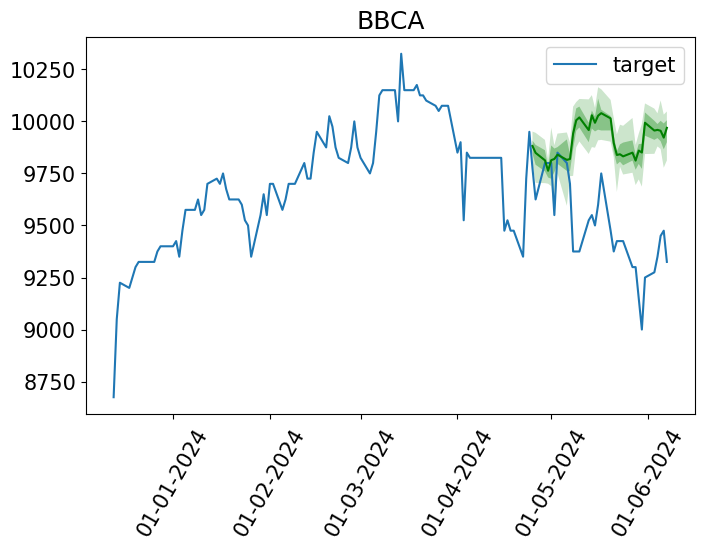

In [44]:
plotting(forecasts_fine_tuning_len_256_lr_1e_2, tss_fine_tuning_len_256_lr_1e_2)

### Get predictions with the default context length ***(512)***

In [45]:
forecasts_fine_tuning_len_512_lr_1e_2, tss_fine_tuning_len_512_lr_1e_2, agg_metrics = lag_llama_fine_tuning(512, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 11.78471 (best 11.78471), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_381\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 10.59229 (best 10.59229), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_381\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 10.44595 (best 10.44595), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_381\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 10.14846 (best 10.14846), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_381\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 9.58453 (best 9.58453), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_381\\checkpoints\\epoch=4-step=250.ckpt

In [46]:
fine_tuning_len_512_lr_1e_2 = print_crps_fine_tuning(512, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.01 CRPS: 0.0231


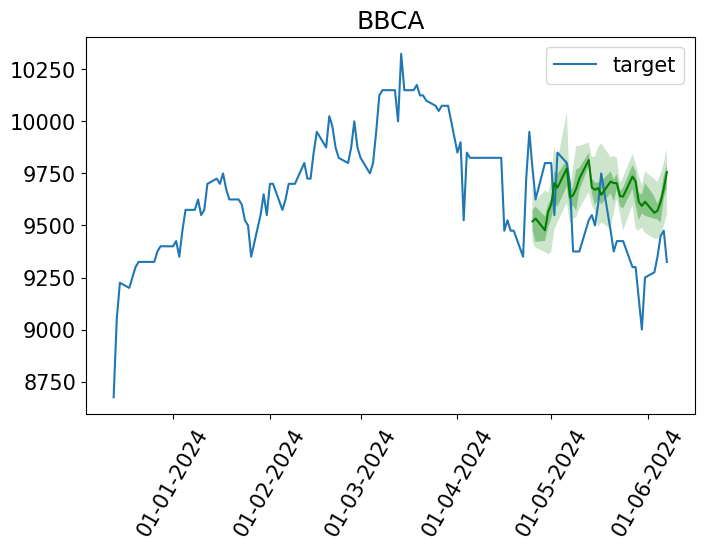

In [47]:
plotting(forecasts_fine_tuning_len_512_lr_1e_2, tss_fine_tuning_len_512_lr_1e_2)

### Get predictions with the default context length ***(1024)***

In [48]:
forecasts_fine_tuning_len_1024_lr_1e_2, tss_fine_tuning_len_1024_lr_1e_2, agg_metrics = lag_llama_fine_tuning(1024, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 11.68468 (best 11.68468), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_384\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 10.63501 (best 10.63501), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_384\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 10.42915 (best 10.42915), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_384\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 10.14653 (best 10.14653), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_384\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 9.97487 (best 9.97487), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightni

In [49]:
fine_tuning_len_1024_lr_1e_2 = print_crps_fine_tuning(1024, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.01 CRPS: 0.0294


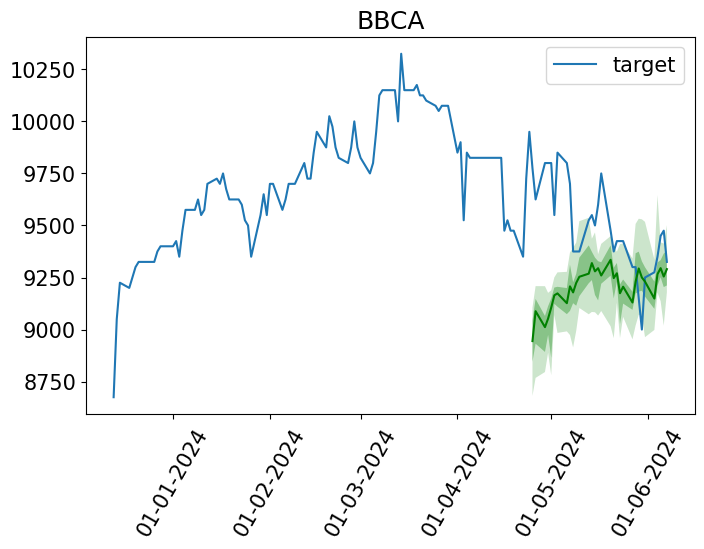

In [50]:
plotting(forecasts_fine_tuning_len_1024_lr_1e_2, tss_fine_tuning_len_1024_lr_1e_2)

### ***Learning Rate 1e-3***

### Get predictions with the default context length ***(32)***

In [51]:
forecasts_fine_tuning_len_32_lr_1e_3, tss_fine_tuning_len_32_lr_1e_3, agg_metrics = lag_llama_fine_tuning(32, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.74644 (best 10.74644), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_389\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 9.64476 (best 9.64476), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_389\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 9.17110 (best 9.17110), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_389\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.92462 (best 8.92462), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_389\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 8.53493 (best 8.53493), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_log

In [52]:
fine_tuning_len_32_lr_1e_3 = print_crps_fine_tuning(32, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.001 CRPS: 0.0860


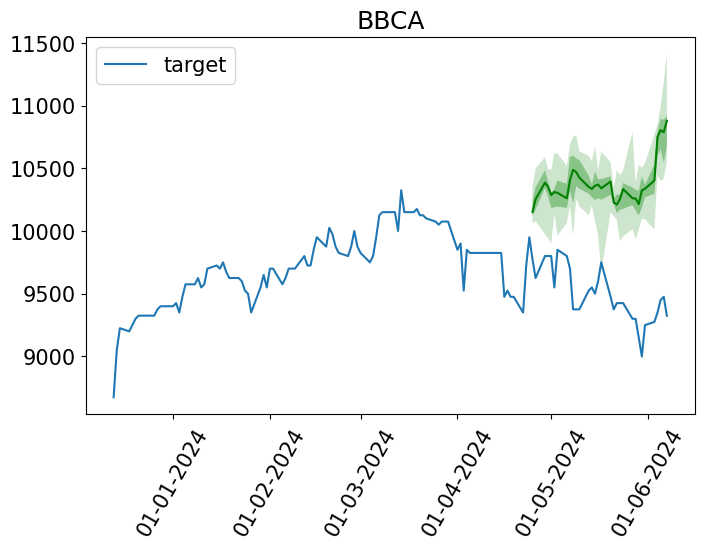

In [53]:
plotting(forecasts_fine_tuning_len_32_lr_1e_3, tss_fine_tuning_len_32_lr_1e_3)

### Get predictions with the default context length ***(64)***

In [54]:
forecasts_fine_tuning_len_64_lr_1e_3, tss_fine_tuning_len_64_lr_1e_3, agg_metrics = lag_llama_fine_tuning(64, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.56981 (best 10.56981), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_390\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 9.38981 (best 9.38981), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_390\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 9.07349 (best 9.07349), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_390\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 8.63906 (best 8.63906), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_390\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 8.46295 (best 8.46295), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_log

In [55]:
fine_tuning_len_64_lr_1e_3 = print_crps_fine_tuning(64, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.001 CRPS: 0.0574


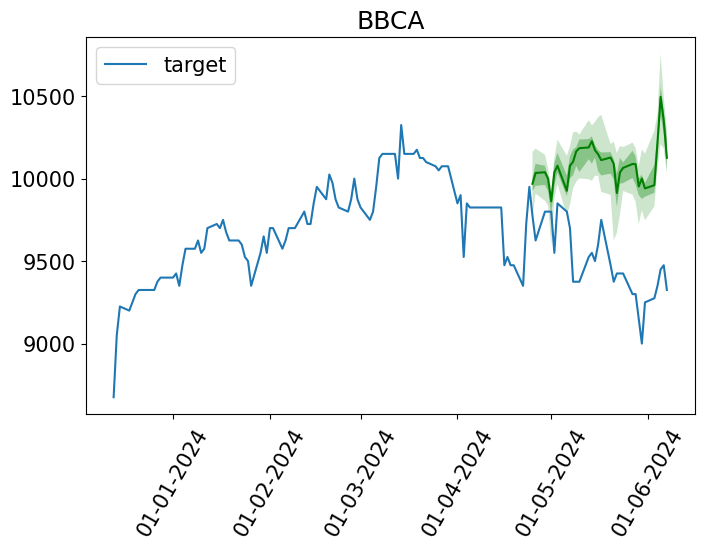

In [56]:
plotting(forecasts_fine_tuning_len_64_lr_1e_3, tss_fine_tuning_len_64_lr_1e_3)

### Get predictions with the default context length ***(128)***

In [57]:
forecasts_fine_tuning_len_128_lr_1e_3, tss_fine_tuning_len_128_lr_1e_3, agg_metrics = lag_llama_fine_tuning(128, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.37213 (best 10.37213), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_391\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 9.61541 (best 9.61541), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_391\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 9.27162 (best 9.27162), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_391\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.73306 (best 8.73306), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_391\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.59762 (best 8.59762), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_391\\checkpoints\\epoch=4-step=250.ckpt' as t

In [58]:
fine_tuning_len_128_lr_1e_3 = print_crps_fine_tuning(128, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.001 CRPS: 0.0637


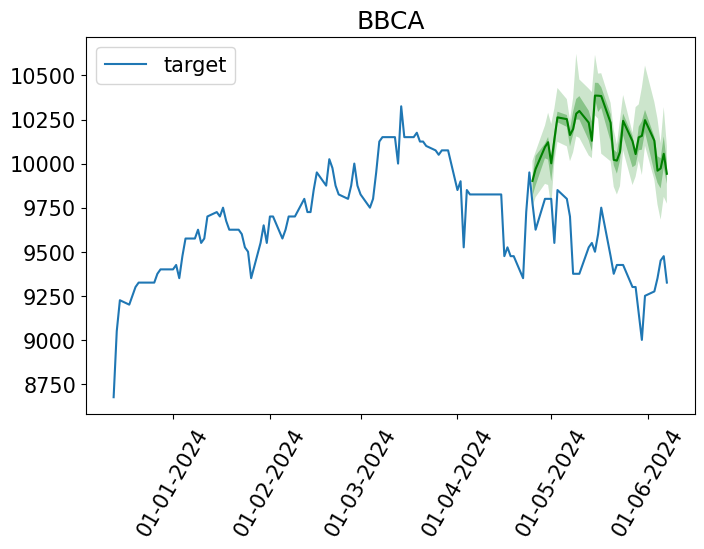

In [59]:
plotting(forecasts_fine_tuning_len_128_lr_1e_3, tss_fine_tuning_len_128_lr_1e_3)

### Get predictions with the default context length ***(256)***

In [60]:
forecasts_fine_tuning_len_256_lr_1e_3, tss_fine_tuning_len_256_lr_1e_3, agg_metrics = lag_llama_fine_tuning(256, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 11.76118 (best 11.76118), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_392\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 9.72606 (best 9.72606), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_392\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 9.68853 (best 9.68853), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_392\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 9.14765 (best 9.14765), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_392\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 8.53342 (best 8.53342), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_log

In [61]:
fine_tuning_len_256_lr_1e_3 = print_crps_fine_tuning(256, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.001 CRPS: 0.0206


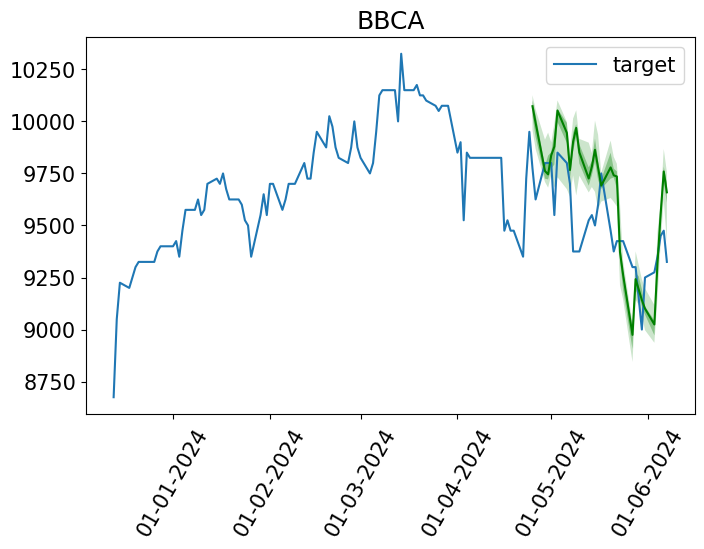

In [62]:
plotting(forecasts_fine_tuning_len_256_lr_1e_3, tss_fine_tuning_len_256_lr_1e_3)

### Get predictions with the default context length ***(512)***

In [63]:
forecasts_fine_tuning_len_512_lr_1e_3, tss_fine_tuning_len_512_lr_1e_3, agg_metrics = lag_llama_fine_tuning(512, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 11.73441 (best 11.73441), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_393\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 9.63741 (best 9.63741), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_393\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 9.05716 (best 9.05716), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_393\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.84814 (best 8.84814), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_393\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.51368 (best 8.51368), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_393\\checkpoints\\epoch=4-step=250.ckpt' as t

In [64]:
fine_tuning_len_512_lr_1e_3 = print_crps_fine_tuning(512, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.001 CRPS: 0.0225


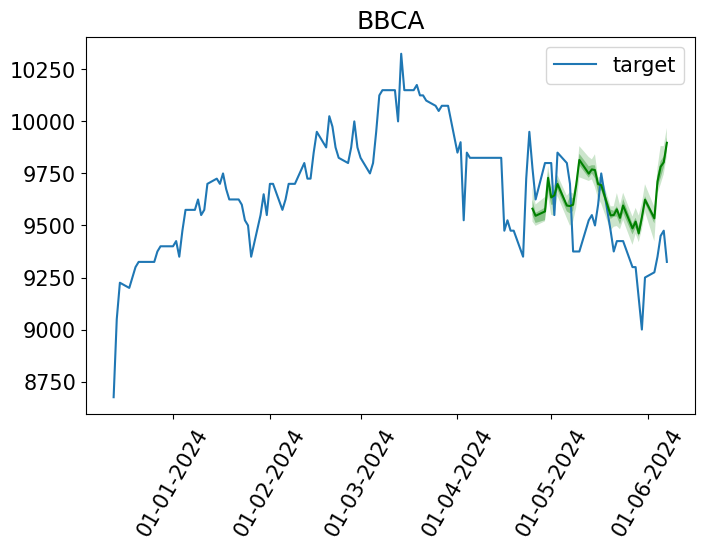

In [65]:
plotting(forecasts_fine_tuning_len_512_lr_1e_3, tss_fine_tuning_len_512_lr_1e_3)

### Get predictions with the default context length ***(1024)***

In [66]:
forecasts_fine_tuning_len_1024_lr_1e_3, tss_fine_tuning_len_1024_lr_1e_3, agg_metrics = lag_llama_fine_tuning(1024, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.41327 (best 10.41327), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_396\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 9.76406 (best 9.76406), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_396\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 9.56790 (best 9.56790), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_396\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 9.27718 (best 9.27718), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_396\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 8.65525 (best 8.65525), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_log

In [67]:
fine_tuning_len_1024_lr_1e_3 = print_crps_fine_tuning(1024, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.001 CRPS: 0.0200


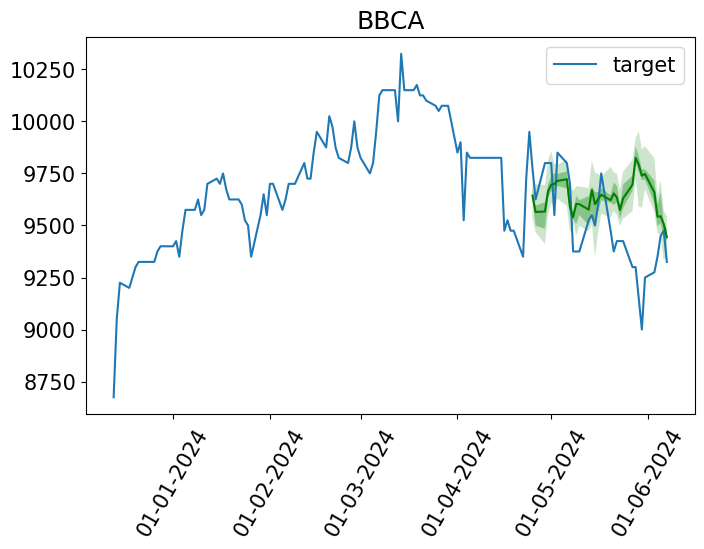

In [68]:
plotting(forecasts_fine_tuning_len_1024_lr_1e_3, tss_fine_tuning_len_1024_lr_1e_3)

### ***Learning Rate 1e-4***

### Get predictions with the default context length ***(32)***

In [69]:
forecasts_fine_tuning_len_32_lr_1e_4, tss_fine_tuning_len_32_lr_1e_4, agg_metrics = lag_llama_fine_tuning(32, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.07585 (best 8.07585), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_401\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.75119 (best 7.75119), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_401\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.42503 (best 7.42503), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_401\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.31728 (best 7.31728), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_401\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 7.25554 (best 7.25554), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [70]:
fine_tuning_len_32_lr_1e_4 = print_crps_fine_tuning(32, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.0001 CRPS: 0.1493


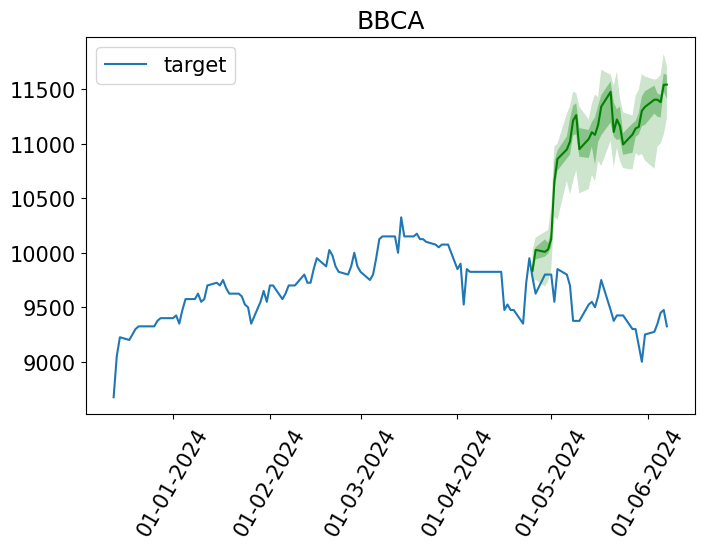

In [71]:
plotting(forecasts_fine_tuning_len_32_lr_1e_4, tss_fine_tuning_len_32_lr_1e_4)

### Get predictions with the default context length ***(64)***

In [72]:
forecasts_fine_tuning_len_64_lr_1e_4, tss_fine_tuning_len_64_lr_1e_4, agg_metrics = lag_llama_fine_tuning(64, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.22120 (best 8.22120), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_402\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.47899 (best 7.47899), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_402\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.35441 (best 7.35441), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_402\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.35254 (best 7.35254), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_402\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.30063 (best 7.30063), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_402\\checkpoints\\epoch=4-step=250.ckpt' as top

In [73]:
fine_tuning_len_64_lr_1e_4 = print_crps_fine_tuning(64, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.0001 CRPS: 0.1585


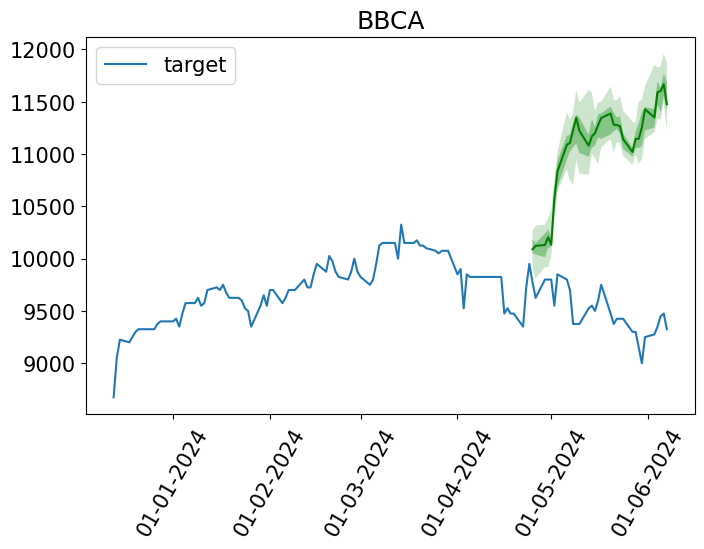

In [74]:
plotting(forecasts_fine_tuning_len_64_lr_1e_4, tss_fine_tuning_len_64_lr_1e_4)

### Get predictions with the default context length ***(128)***

In [75]:
forecasts_fine_tuning_len_128_lr_1e_4, tss_fine_tuning_len_128_lr_1e_4, agg_metrics = lag_llama_fine_tuning(128, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.24876 (best 8.24876), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_403\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.61135 (best 7.61135), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_403\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.36057 (best 7.36057), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_403\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.32973 (best 7.32973), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_403\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.29188 (best 7.29188), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_403\\checkpoints\\epoch=4-step=250.ckpt' as top

In [76]:
fine_tuning_len_128_lr_1e_4 = print_crps_fine_tuning(128, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.0001 CRPS: 0.1611


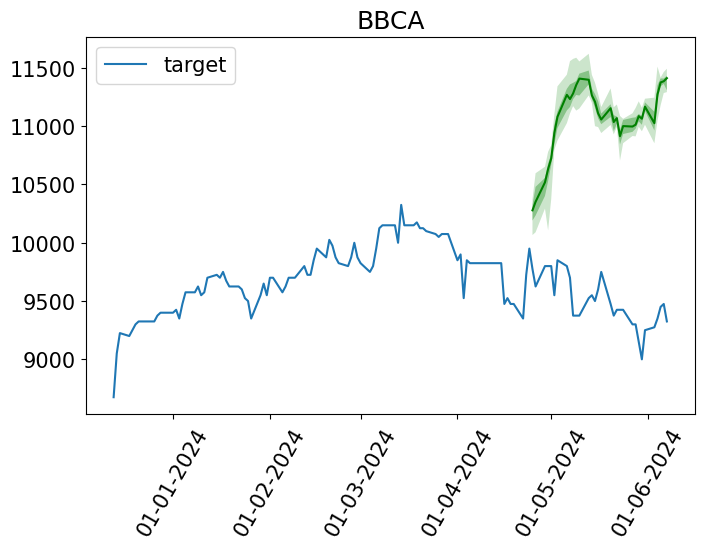

In [77]:
plotting(forecasts_fine_tuning_len_128_lr_1e_4, tss_fine_tuning_len_128_lr_1e_4)

### Get predictions with the default context length ***(256)***

In [78]:
forecasts_fine_tuning_len_256_lr_1e_4, tss_fine_tuning_len_256_lr_1e_4, agg_metrics = lag_llama_fine_tuning(256, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.42292 (best 8.42292), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_404\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.57540 (best 7.57540), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_404\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.47560 (best 7.47560), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_404\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.45099 (best 7.45099), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_404\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.32851 (best 7.32851), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_404\\checkpoints\\epoch=4-step=250.ckpt' as top

In [79]:
fine_tuning_len_256_lr_1e_4 = print_crps_fine_tuning(256, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.0001 CRPS: 0.1258


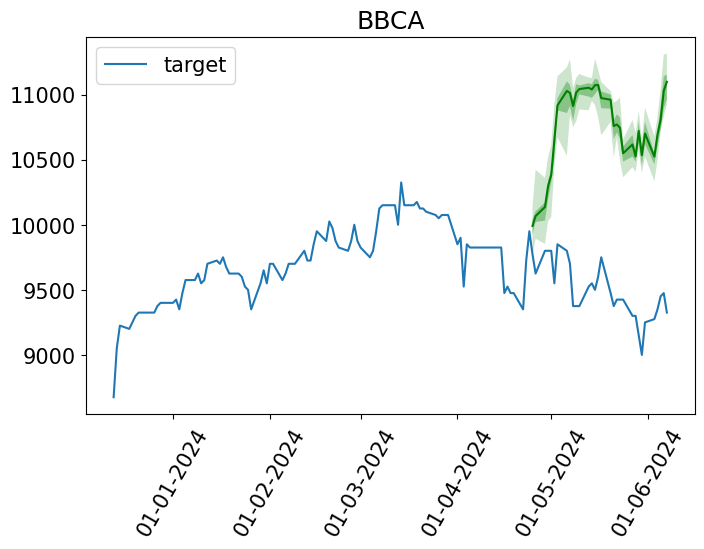

In [80]:
plotting(forecasts_fine_tuning_len_256_lr_1e_4, tss_fine_tuning_len_256_lr_1e_4)

### Get predictions with the default context length ***(512)***

In [81]:
forecasts_fine_tuning_len_512_lr_1e_4, tss_fine_tuning_len_512_lr_1e_4, agg_metrics = lag_llama_fine_tuning(512, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.40118 (best 8.40118), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_405\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.75841 (best 7.75841), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_405\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.63115 (best 7.63115), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_405\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.62600 (best 7.62600), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_405\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.46529 (best 7.46529), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_405\\checkpoints\\epoch=4-step=250.ckpt' as top

In [82]:
fine_tuning_len_512_lr_1e_4 = print_crps_fine_tuning(512, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.0001 CRPS: 0.0603


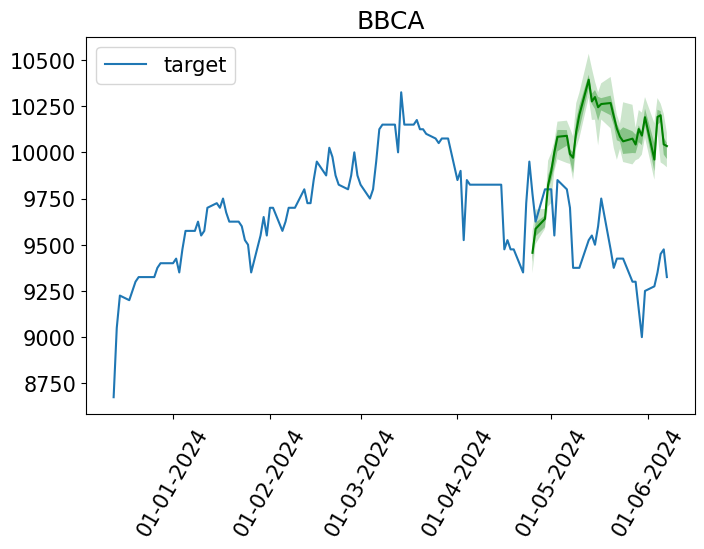

In [83]:
plotting(forecasts_fine_tuning_len_512_lr_1e_4, tss_fine_tuning_len_512_lr_1e_4)

### Get predictions with the default context length ***(1024)***

In [84]:
forecasts_fine_tuning_len_1024_lr_1e_4, tss_fine_tuning_len_1024_lr_1e_4, agg_metrics = lag_llama_fine_tuning(1024, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.44064 (best 8.44064), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_407\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.78738 (best 7.78738), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_407\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.62717 (best 7.62717), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_407\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.55975 (best 7.55975), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_407\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.55551 (best 7.55551), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_407\\checkpoints\\epoch=4-step=250.ckpt' as top

In [85]:
fine_tuning_len_1024_lr_1e_4 = print_crps_fine_tuning(1024, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.0001 CRPS: 0.0581


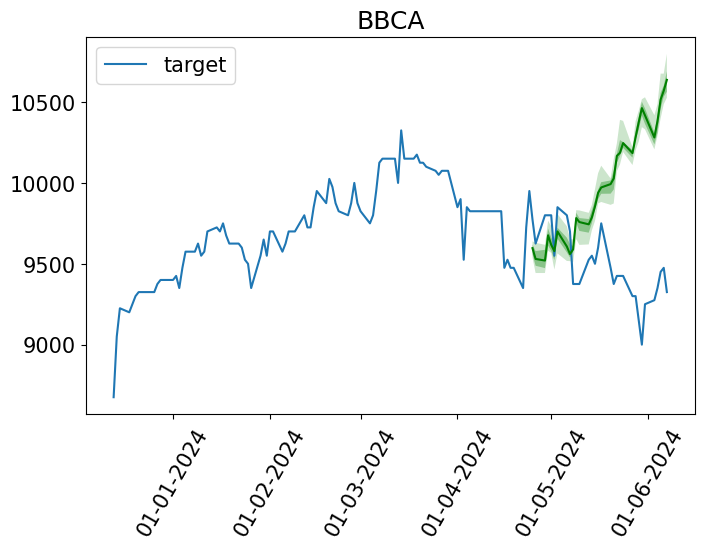

In [86]:
plotting(forecasts_fine_tuning_len_1024_lr_1e_4, tss_fine_tuning_len_1024_lr_1e_4)

### ***Learning Rate 5e-3***

### Get predictions with the default context length ***(32)***

In [87]:
forecasts_fine_tuning_len_32_lr_5e_3, tss_fine_tuning_len_32_lr_5e_3, agg_metrics = lag_llama_fine_tuning(32, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 11.81399 (best 11.81399), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_413\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 10.82910 (best 10.82910), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_413\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 9.87019 (best 9.87019), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_413\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 9.29291 (best 9.29291), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_413\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 8.89406 (best 8.89406), saving mode

In [88]:
fine_tuning_len_32_lr_5e_3 = print_crps_fine_tuning(32, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.005 CRPS: 0.0521


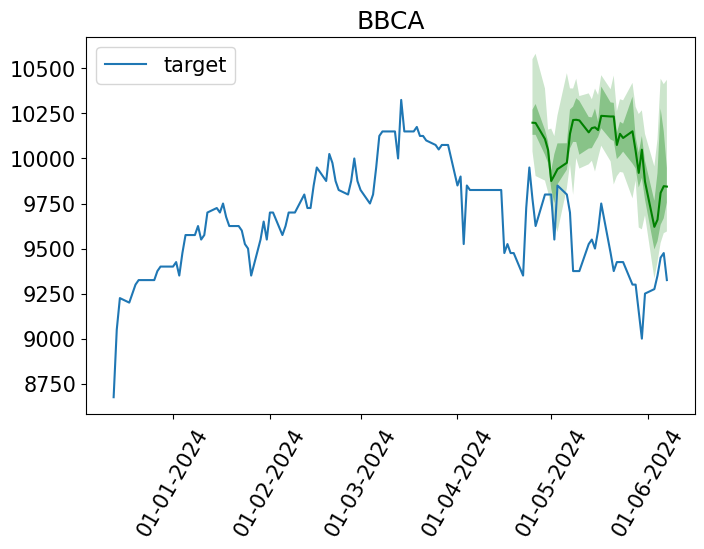

In [89]:
plotting(forecasts_fine_tuning_len_32_lr_5e_3, tss_fine_tuning_len_32_lr_5e_3)

### Get predictions with the default context length ***(64)***

In [90]:
forecasts_fine_tuning_len_64_lr_5e_3, tss_fine_tuning_len_64_lr_5e_3, agg_metrics = lag_llama_fine_tuning(64, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 11.71224 (best 11.71224), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_414\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 10.79762 (best 10.79762), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_414\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 9.91814 (best 9.91814), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_414\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 9.81569 (best 9.81569), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_414\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 9.57753 (best 9.57753), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_l

In [91]:
fine_tuning_len_64_lr_5e_3 = print_crps_fine_tuning(64, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.005 CRPS: 0.0333


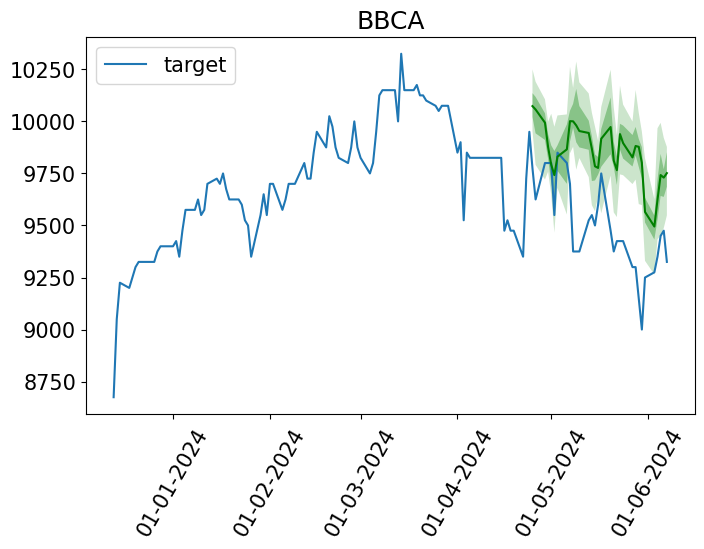

In [92]:
plotting(forecasts_fine_tuning_len_64_lr_5e_3, tss_fine_tuning_len_64_lr_5e_3)

### Get predictions with the default context length ***(128)***

In [93]:
forecasts_fine_tuning_len_128_lr_5e_3, tss_fine_tuning_len_128_lr_5e_3, agg_metrics = lag_llama_fine_tuning(128, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 11.62862 (best 11.62862), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_415\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 10.68083 (best 10.68083), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_415\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 10.05498 (best 10.05498), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_415\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 9.82347 (best 9.82347), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_415\\checkpoints\\epoch=6-step=350.ckpt' as top 1
Epoch 7, global step 400

In [94]:
fine_tuning_len_128_lr_5e_3 = print_crps_fine_tuning(128, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.005 CRPS: 0.0217


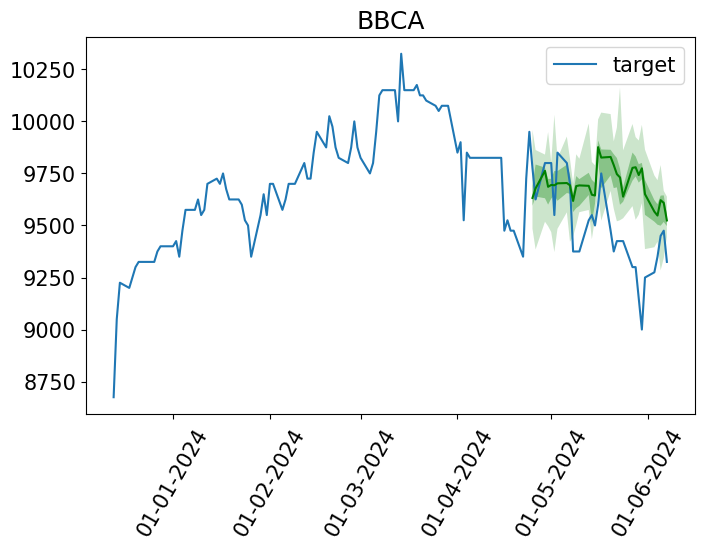

In [95]:
plotting(forecasts_fine_tuning_len_128_lr_5e_3, tss_fine_tuning_len_128_lr_5e_3)

### Get predictions with the default context length ***(256)***

In [96]:
forecasts_fine_tuning_len_256_lr_5e_3, tss_fine_tuning_len_256_lr_5e_3, agg_metrics = lag_llama_fine_tuning(256, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 11.50512 (best 11.50512), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_416\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 10.69258 (best 10.69258), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_416\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 10.64261 (best 10.64261), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_416\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 10.63218 (best 10.63218), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_416\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' reached 10.29938 (best 10.29938), savin

In [97]:
fine_tuning_len_256_lr_5e_3 = print_crps_fine_tuning(256, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.005 CRPS: 0.0231


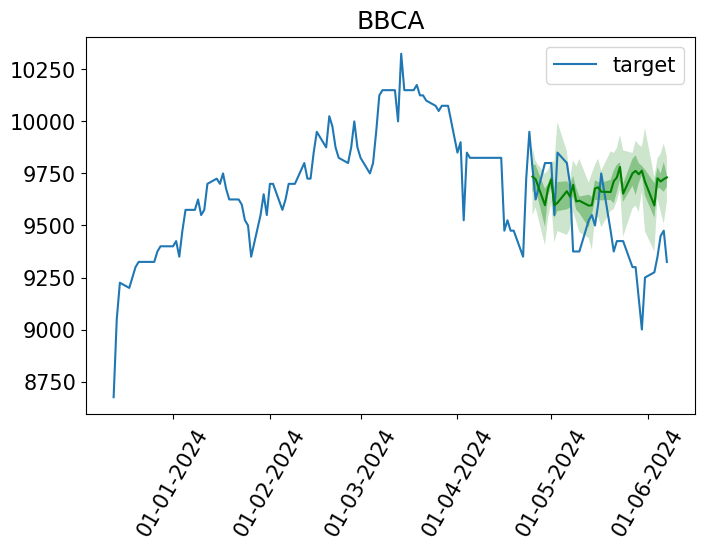

In [98]:
plotting(forecasts_fine_tuning_len_256_lr_5e_3, tss_fine_tuning_len_256_lr_5e_3)

### Get predictions with the default context length ***(512)***

In [99]:
forecasts_fine_tuning_len_512_lr_5e_3, tss_fine_tuning_len_512_lr_5e_3, agg_metrics = lag_llama_fine_tuning(512, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 11.30703 (best 11.30703), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_417\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 10.52123 (best 10.52123), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_417\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 9.85648 (best 9.85648), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_417\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 9.44899 (best 9.44899), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_417\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 9.17453 (best 9.17453), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_l

In [100]:
fine_tuning_len_512_lr_5e_3 = print_crps_fine_tuning(512, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.005 CRPS: 0.0155


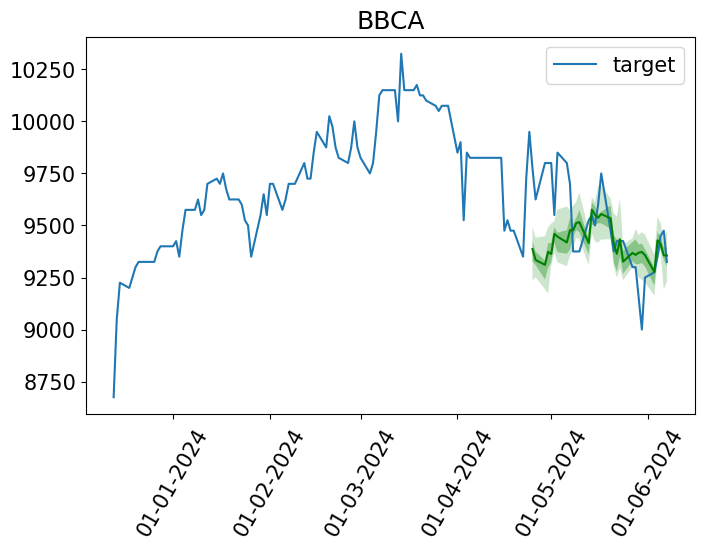

In [101]:
plotting(forecasts_fine_tuning_len_512_lr_5e_3, tss_fine_tuning_len_512_lr_5e_3)

### Get predictions with the default context length ***(1024)***

In [102]:
forecasts_fine_tuning_len_1024_lr_5e_3, tss_fine_tuning_len_1024_lr_5e_3, agg_metrics = lag_llama_fine_tuning(1024, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 11.73469 (best 11.73469), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_419\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 10.60890 (best 10.60890), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_419\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 10.54617 (best 10.54617), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_419\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 10.17523 (best 10.17523), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_419\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 10.07321 (best 10.07321), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_419\\checkpoints\\epoch=4-step=250.ck

In [103]:
fine_tuning_len_1024_lr_5e_3 = print_crps_fine_tuning(1024, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.005 CRPS: 0.0471


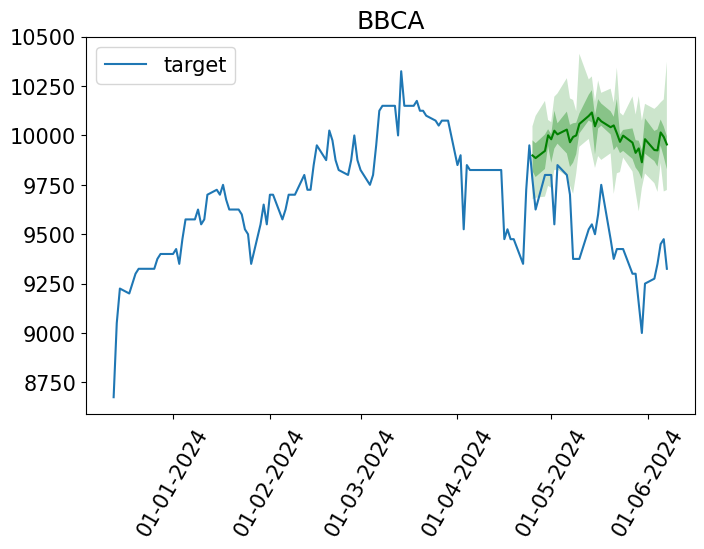

In [104]:
plotting(forecasts_fine_tuning_len_1024_lr_5e_3, tss_fine_tuning_len_1024_lr_5e_3)

### ***Learning Rate 5e-4***

### Get predictions with the default context length ***(32)***

In [19]:
forecasts_fine_tuning_len_32_lr_5e_4, tss_fine_tuning_len_32_lr_5e_4, agg_metrics = lag_llama_fine_tuning(32, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.83080 (best 9.83080), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_434\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.93444 (best 8.93444), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_434\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.47332 (best 8.47332), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_434\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.20055 (best 8.20055), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_434\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.01581 (best 8.01581), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_434\\checkpoints\\epoch=4-step=250.ckpt' as top

In [20]:
fine_tuning_len_32_lr_5e_4 = print_crps_fine_tuning(32, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.0005 CRPS: 0.1494


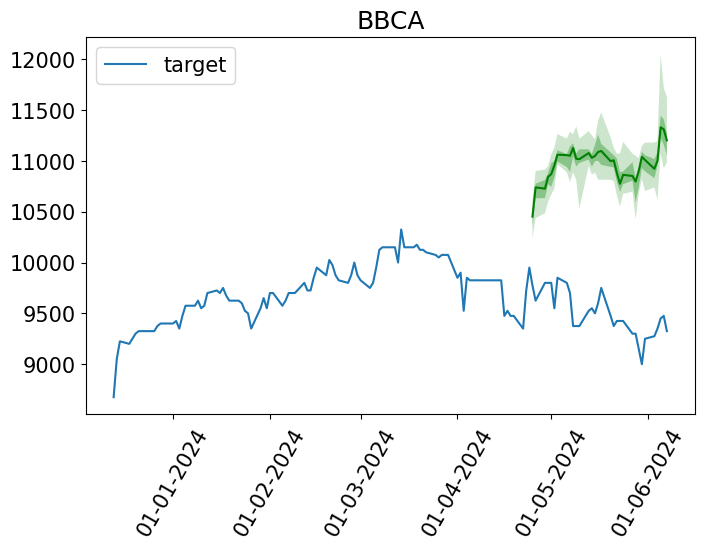

In [21]:
plotting(forecasts_fine_tuning_len_32_lr_5e_4, tss_fine_tuning_len_32_lr_5e_4)

### Get predictions with the default context length ***(64)***

In [22]:
forecasts_fine_tuning_len_64_lr_5e_4, tss_fine_tuning_len_64_lr_5e_4, agg_metrics = lag_llama_fine_tuning(64, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.24051 (best 10.24051), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_436\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 9.13838 (best 9.13838), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_436\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.41364 (best 8.41364), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_436\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 8.01382 (best 8.01382), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_436\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' reached 7.76022 (best 7.76022), saving model 

In [23]:
fine_tuning_len_64_lr_5e_4 = print_crps_fine_tuning(64, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.0005 CRPS: 0.1375


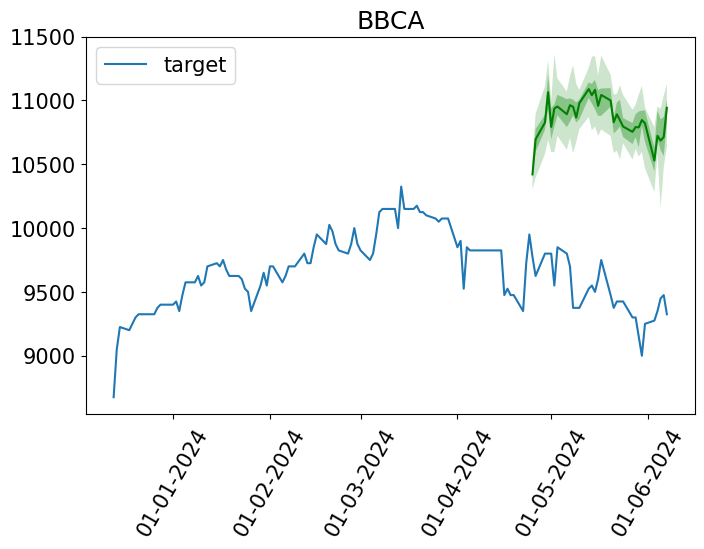

In [24]:
plotting(forecasts_fine_tuning_len_64_lr_5e_4, tss_fine_tuning_len_64_lr_5e_4)

### Get predictions with the default context length ***(128)***

In [25]:
forecasts_fine_tuning_len_128_lr_5e_4, tss_fine_tuning_len_128_lr_5e_4, agg_metrics = lag_llama_fine_tuning(128, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.05132 (best 10.05132), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_438\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.70517 (best 8.70517), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_438\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.47279 (best 8.47279), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_438\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.18621 (best 8.18621), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_438\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.04873 (best 8.04873), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_438\\checkpoints\\epoch=4-step=250.ckpt' as t

In [26]:
fine_tuning_len_128_lr_5e_4 = print_crps_fine_tuning(128, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.0005 CRPS: 0.1481


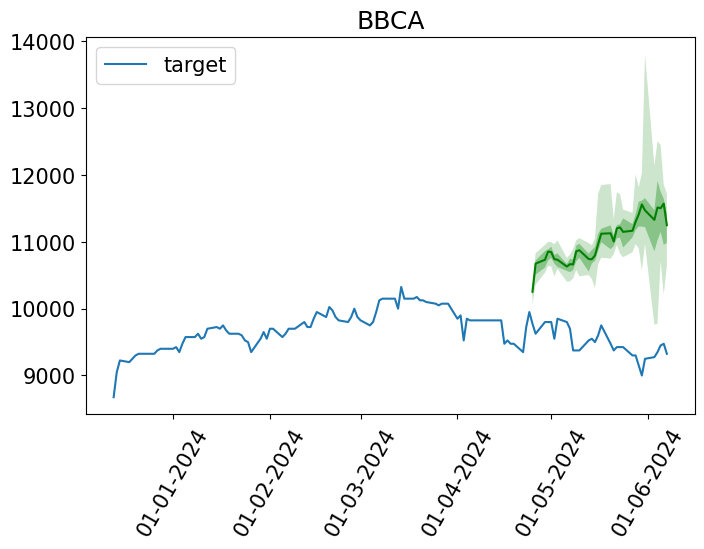

In [27]:
plotting(forecasts_fine_tuning_len_128_lr_5e_4, tss_fine_tuning_len_128_lr_5e_4)

### Get predictions with the default context length ***(256)***

In [28]:
forecasts_fine_tuning_len_256_lr_5e_4, tss_fine_tuning_len_256_lr_5e_4, agg_metrics = lag_llama_fine_tuning(256, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.49698 (best 10.49698), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_440\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 9.35794 (best 9.35794), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_440\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 9.08179 (best 9.08179), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_440\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.47443 (best 8.47443), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_440\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.30455 (best 8.30455), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_440\\checkpoints\\epoch=4-step=250.ckpt' as t

In [29]:
fine_tuning_len_256_lr_5e_4 = print_crps_fine_tuning(256, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.0005 CRPS: 0.0263


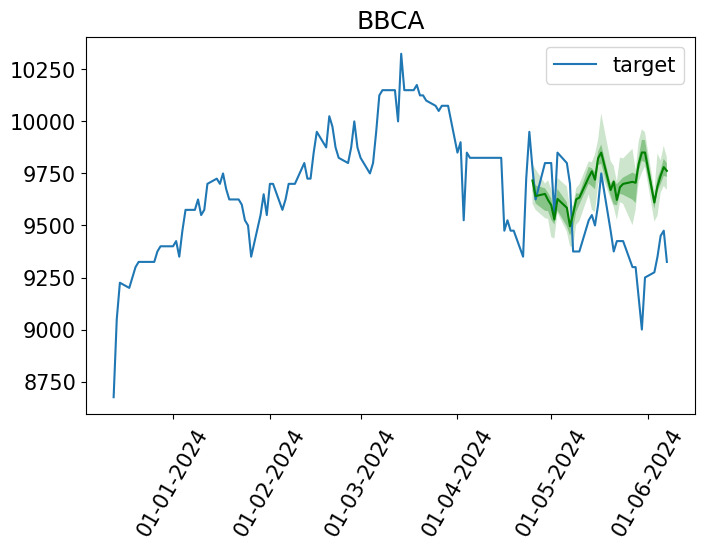

In [30]:
plotting(forecasts_fine_tuning_len_256_lr_5e_4, tss_fine_tuning_len_256_lr_5e_4)

### Get predictions with the default context length ***(512)***

In [31]:
forecasts_fine_tuning_len_512_lr_5e_4, tss_fine_tuning_len_512_lr_5e_4, agg_metrics = lag_llama_fine_tuning(512, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.99155 (best 9.99155), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_442\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.65851 (best 8.65851), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_442\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.41579 (best 8.41579), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_442\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.18798 (best 8.18798), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_442\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.95873 (best 7.95873), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_442\\checkpoints\\epoch=4-step=250.ckpt' as top

In [32]:
fine_tuning_len_512_lr_5e_4 = print_crps_fine_tuning(512, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.0005 CRPS: 0.0233


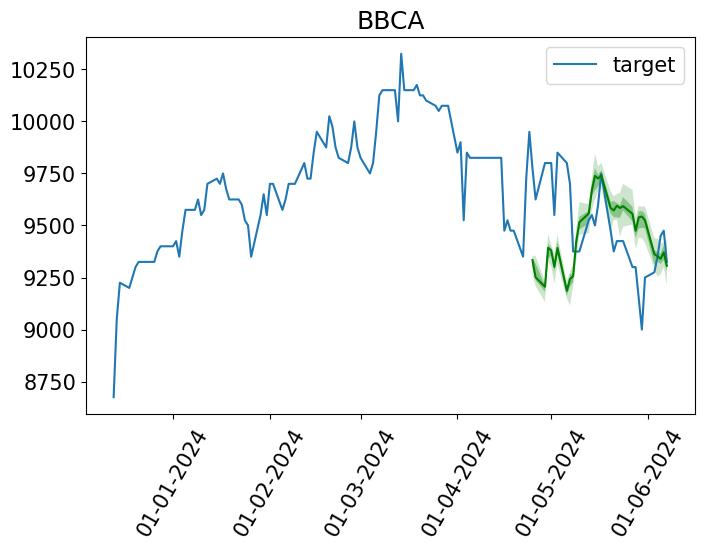

In [33]:
plotting(forecasts_fine_tuning_len_512_lr_5e_4, tss_fine_tuning_len_512_lr_5e_4)

### Get predictions with the default context length ***(1024)***

In [34]:
forecasts_fine_tuning_len_1024_lr_5e_4, tss_fine_tuning_len_1024_lr_5e_4, agg_metrics = lag_llama_fine_tuning(1024, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.58043 (best 9.58043), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_444\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.74998 (best 8.74998), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_444\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 8.38173 (best 8.38173), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_444\\checkpoints\\epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' reached 8.00064 (best 8.00064), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_444\\checkpoints\\epoch=6-step=350.ckpt' as top 1
Epoch 7, global step 400: 'tra

In [35]:
fine_tuning_len_1024_lr_5e_4 = print_crps_fine_tuning(1024, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.0005 CRPS: 0.0388


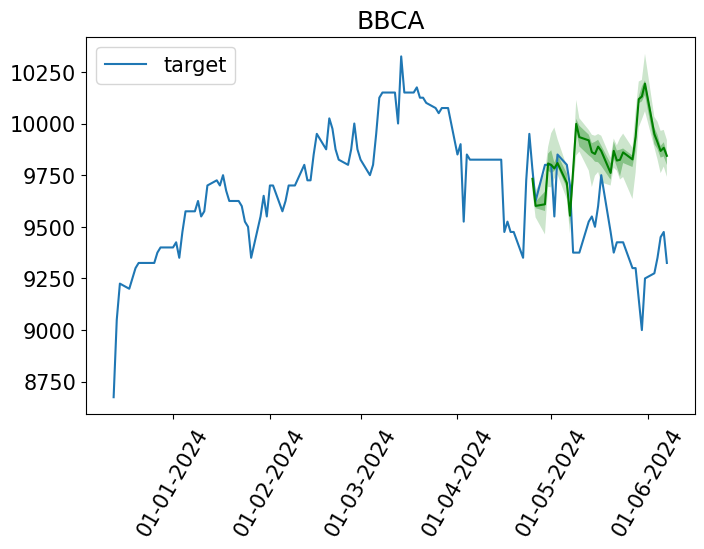

In [36]:
plotting(forecasts_fine_tuning_len_1024_lr_5e_4, tss_fine_tuning_len_1024_lr_5e_4)

### ***Learning Rate 5e-5***

### Get predictions with the default context length ***(32)***

In [37]:
forecasts_fine_tuning_len_32_lr_5e_5, tss_fine_tuning_len_32_lr_5e_5, agg_metrics = lag_llama_fine_tuning(32, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.66381 (best 7.66381), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_445\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.26366 (best 7.26366), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_445\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.18816 (best 7.18816), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_445\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.07739 (best 7.07739), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_445\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 7.04399 (best 7.04399), saving model to

In [38]:
fine_tuning_len_32_lr_5e_5 = print_crps_fine_tuning(32, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 5e-05 CRPS: 0.2076


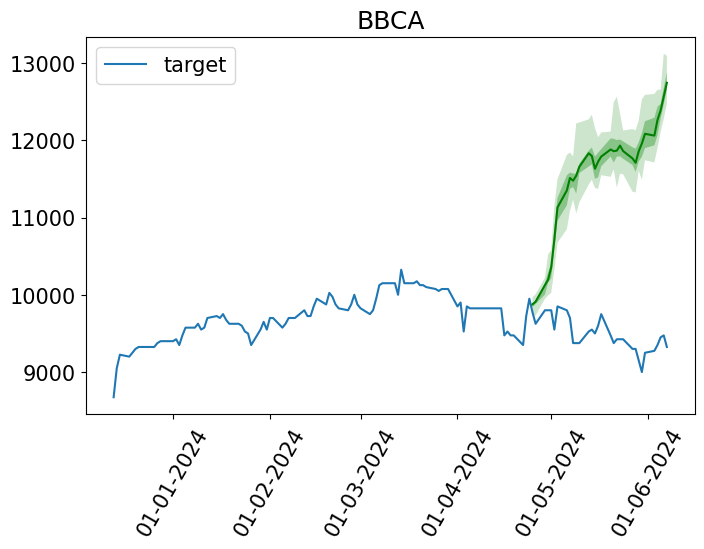

In [39]:
plotting(forecasts_fine_tuning_len_32_lr_5e_5, tss_fine_tuning_len_32_lr_5e_5)

### Get predictions with the default context length ***(64)***

In [40]:
forecasts_fine_tuning_len_64_lr_5e_5, tss_fine_tuning_len_64_lr_5e_5, agg_metrics = lag_llama_fine_tuning(64, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.67978 (best 7.67978), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_446\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.25944 (best 7.25944), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_446\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.23412 (best 7.23412), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_446\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.15153 (best 7.15153), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_446\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.13008 (best 7.13008), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_446\\checkpoints\\epoch=4-step=250.ckpt' as top

In [41]:
fine_tuning_len_64_lr_5e_5 = print_crps_fine_tuning(64, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 5e-05 CRPS: 0.1650


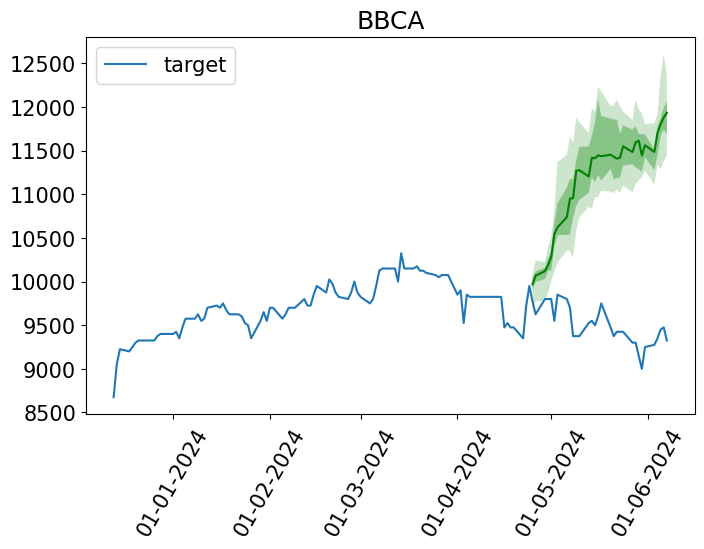

In [42]:
plotting(forecasts_fine_tuning_len_64_lr_5e_5, tss_fine_tuning_len_64_lr_5e_5)

### Get predictions with the default context length ***(128)***

In [43]:
forecasts_fine_tuning_len_128_lr_5e_5, tss_fine_tuning_len_128_lr_5e_5, agg_metrics = lag_llama_fine_tuning(128, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.83122 (best 7.83122), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_447\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.33538 (best 7.33538), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_447\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.25902 (best 7.25902), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_447\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.20430 (best 7.20430), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_447\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 7.17746 (best 7.17746), saving model to

In [44]:
fine_tuning_len_128_lr_5e_5 = print_crps_fine_tuning(128, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 5e-05 CRPS: 0.1923


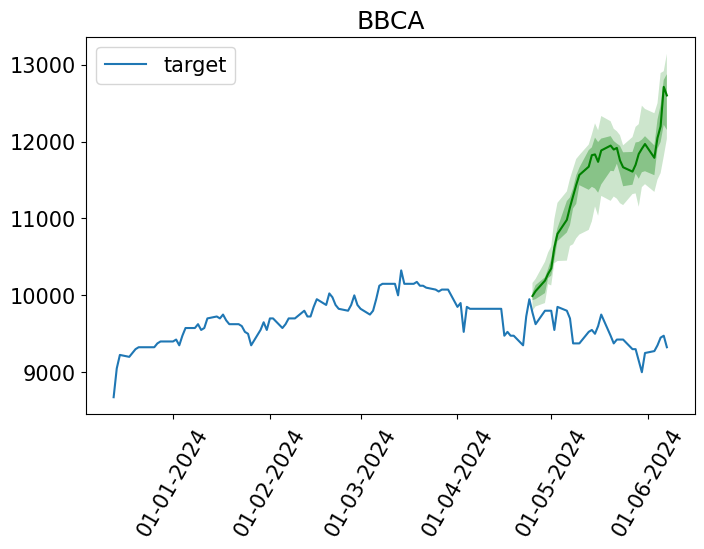

In [45]:
plotting(forecasts_fine_tuning_len_128_lr_5e_5, tss_fine_tuning_len_128_lr_5e_5)

### Get predictions with the default context length ***(256)***

In [46]:
forecasts_fine_tuning_len_256_lr_5e_5, tss_fine_tuning_len_256_lr_5e_5, agg_metrics = lag_llama_fine_tuning(256, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.97001 (best 7.97001), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_448\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.46377 (best 7.46377), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_448\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.37190 (best 7.37190), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_448\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.29788 (best 7.29788), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_448\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.24636 (best 7.24636), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_448\\checkpoints\\epoch=4-step=250.ckpt' as top

In [47]:
fine_tuning_len_256_lr_5e_5 = print_crps_fine_tuning(256, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 5e-05 CRPS: 0.1630


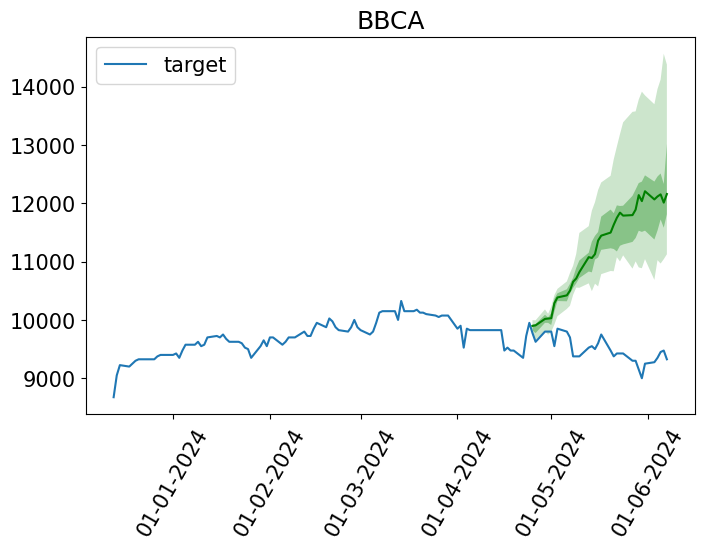

In [48]:
plotting(forecasts_fine_tuning_len_256_lr_5e_5, tss_fine_tuning_len_256_lr_5e_5)

### Get predictions with the default context length ***(512)***

In [49]:
forecasts_fine_tuning_len_512_lr_5e_5, tss_fine_tuning_len_512_lr_5e_5, agg_metrics = lag_llama_fine_tuning(512, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.04074 (best 8.04074), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_449\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.71550 (best 7.71550), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_449\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.47128 (best 7.47128), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_449\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.44962 (best 7.44962), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_449\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 7.44773 (best 7.44773), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [50]:
fine_tuning_len_512_lr_5e_5 = print_crps_fine_tuning(512, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 5e-05 CRPS: 0.0567


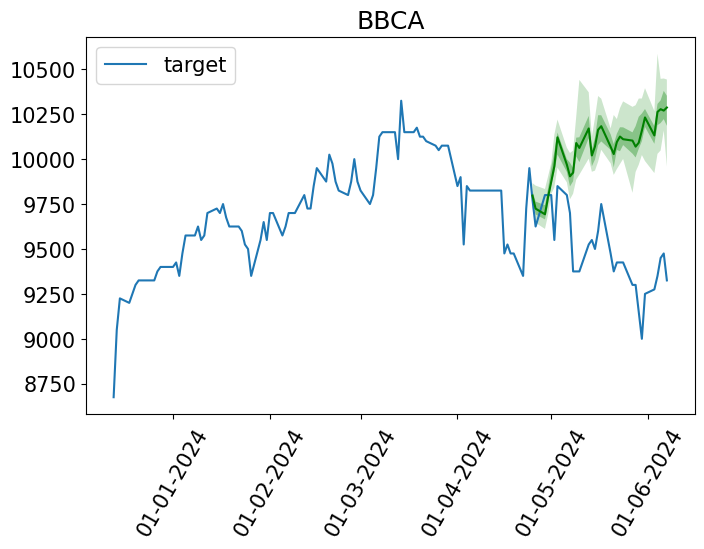

In [51]:
plotting(forecasts_fine_tuning_len_512_lr_5e_5, tss_fine_tuning_len_512_lr_5e_5)

### Get predictions with the default context length ***(1024)***

In [52]:
forecasts_fine_tuning_len_1024_lr_5e_5, tss_fine_tuning_len_1024_lr_5e_5, agg_metrics = lag_llama_fine_tuning(1024, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.17329 (best 8.17329), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_450\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.66181 (best 7.66181), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_450\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.57179 (best 7.57179), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_450\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.50188 (best 7.50188), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_450\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.43562 (best 7.43562), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_450\\checkpoints\\epoch=4-step=250.ckpt' as top

In [53]:
fine_tuning_len_1024_lr_5e_5 = print_crps_fine_tuning(1024, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 5e-05 CRPS: 0.0700


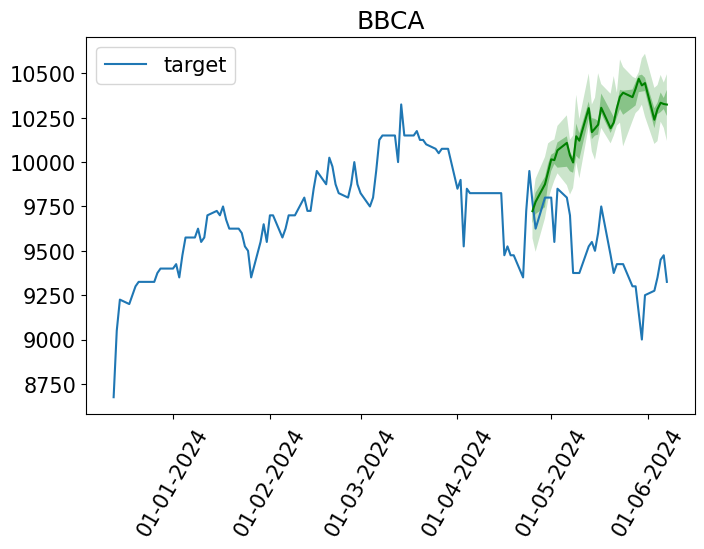

In [54]:
plotting(forecasts_fine_tuning_len_1024_lr_5e_5, tss_fine_tuning_len_1024_lr_5e_5)

# **Compared to TFT and DeepAR**

In [106]:
tft_estimator = TemporalFusionTransformerEstimator(
    prediction_length=prediction_length,
    context_length=32,
    freq="B",
    batch_size=batch_size,
    trainer_kwargs={"max_epochs": epoch}
)
deepar_estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=32,
    freq="B",
    batch_size=batch_size,
    trainer_kwargs={"max_epochs": epoch}
)

In [107]:
tft_predictor = tft_estimator.train(backtrain_dataset)
deepar_predictor = deepar_estimator.train(backtrain_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                           | Params | In sizes                                                                           | Out sizes 
-----------------------------------------------------------------------------------------------------------------------------------------------------------
0 | model | TemporalFusionTransformerModel | 109 K  | [[1, 32], [1, 32], [1, 1], [1, 1], [1, 64, 3], [1, 64, 0], [1, 32, 0], [1, 32, 0]] | [1, 9, 32]
-----------------------------------------------------------------------------------------------------------------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.439     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 19700.80664 (best 19700.80664), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_428\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 16500.99414 (best 16500.99414), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_428\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 15137.38867 (best 15137.38867), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_428\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 13947.56543 (best 13947.56543), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_428\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 12993.82715 (best 12993.82715), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_428\\ch

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.18440 (best 10.18440), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_431\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.75651 (best 8.75651), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_431\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.66391 (best 8.66391), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_431\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.61433 (best 8.61433), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_431\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.41424 (best 8.41424), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_431\\checkpoints\\epoch=4-step=250.ckpt' as t

In [108]:
tft_forecast_it, tft_ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=tft_predictor,
)

deepar_forecast_it, deepar_ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=deepar_predictor,
)

tft_forecasts = list(tft_forecast_it)
tft_tss = list(tft_ts_it)

deepar_forecasts = list(deepar_forecast_it)
deepar_tss = list(deepar_ts_it)

evaluator = Evaluator()
tft_agg_metrics, tft_ts_metrics = evaluator(iter(tft_tss), iter(tft_forecasts))
deepar_agg_metrics, deepar_ts_metrics = evaluator(iter(deepar_tss), iter(deepar_forecasts))

Running evaluation: 0it [00:00, ?it/s]The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
Running evaluation: 1it [00:00, 151.33it/s]
Running evaluation: 1it [00:00, 166.51it/s]


In [109]:
print(f"Temporal Fusion Transformer CRPS: {tft_agg_metrics['mean_wQuantileLoss']:.4f}")

Temporal Fusion Transformer CRPS: 0.0373


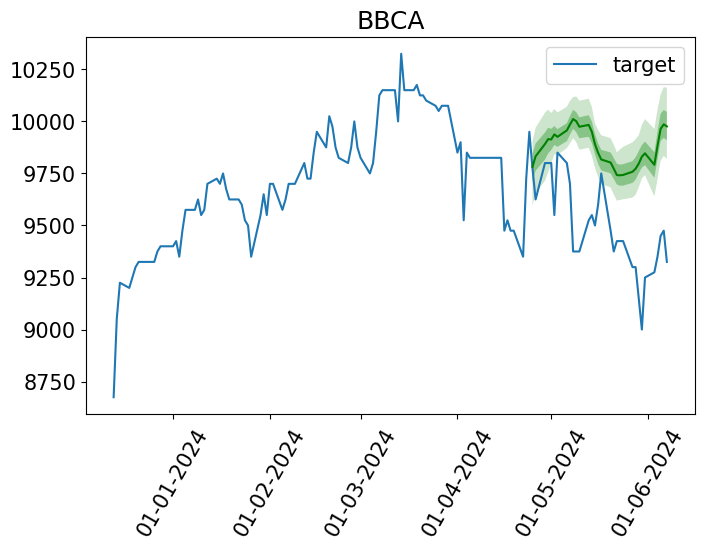

In [110]:
plotting(tft_forecasts, tft_tss)

In [111]:
print(f"DeepAR CRPS: {deepar_agg_metrics['mean_wQuantileLoss']:.4f}")

DeepAR CRPS: 0.0170


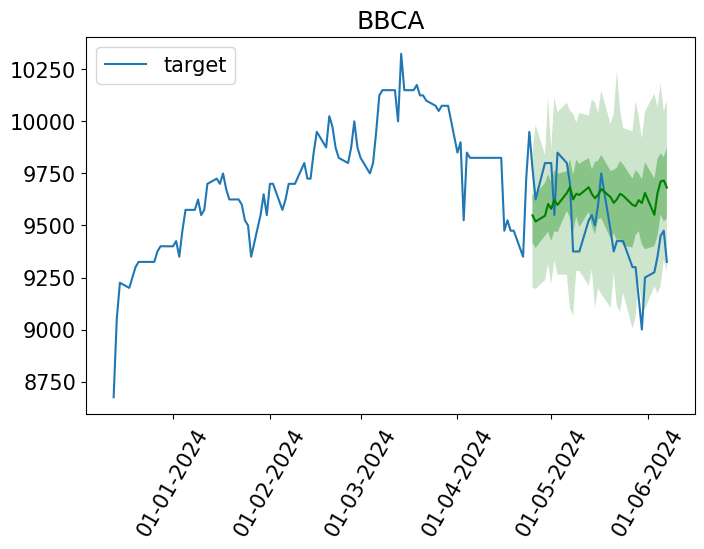

In [112]:
plotting(deepar_forecasts, deepar_tss)

# **Summary**

In [2]:
context_length = [32, 64, 128, 256, 512, 1024]
learning_rates = ['1e-2', '1e-3', '1e-4', '5e-3', '5e-4', '5e-5']

print("\n\033[1mLag-Llama Zero-Shot\033[0m")

# Lag-Llama Zero-Shot (False)
print("\n\033[1mRope scaled (False)\033[0m")
for length in context_length[:2]:
    print(f"Lag-Llama Zero-Shot ({length}) rope_scaled (False) CRPS: {globals()[f'zero_shot_len_{length}_false']:.4f}")

# Lag-Llama Zero-Shot (True)
print("\n\033[1mRope scaled (True)\033[0m")
for length in context_length[1:]:
    print(f"Lag-Llama Zero-Shot ({length}) rope_scaled (True) CRPS: {globals()[f'zero_shot_len_{length}_true']:.4f}")

# Lag-Llama Fine-Tuning
print("\n\033[1mLag-Llama Fine-Tuning\033[0m")
for lr in learning_rates:
    print(f"\n\033[1mLearning rate {lr}\033[0m")
    for length in context_length:
        variable_name = f"fine_tuning_len_{length}_lr_{lr.replace('-', '_')}"
        print(f"Lag-Llama Fine-Tuning ({length}) Lr {lr} CRPS: {globals()[variable_name]:.4f}")


print("\n\033[1mComparation Temporal Fusion Transformer (TFT) and DeepAR\033[0m")
print(f"Temporal Fusion Transformer CRPS: {tft_agg_metrics['mean_wQuantileLoss']:.4f}")
print(f"DeepAR CRPS: {deepar_agg_metrics['mean_wQuantileLoss']:.4f}")


Lag-Llama Zero-Shot

Rope scaled (False)
Lag-Llama Zero-Shot (32) rope_scaled (False) CRPS: 0.0313
Lag-Llama Zero-Shot (64) rope_scaled (False) CRPS: 0.0383

Rope scaled (True)
Lag-Llama Zero-Shot (64) rope_scaled (True) CRPS: 0.0365
Lag-Llama Zero-Shot (128) rope_scaled (True) CRPS: 0.0374
Lag-Llama Zero-Shot (256) rope_scaled (True) CRPS: 0.0348
Lag-Llama Zero-Shot (512) rope_scaled (True) CRPS: 0.0459
Lag-Llama Zero-Shot (1024) rope_scaled (True) CRPS: 0.0461

Lag-Llama Fine-Tuning

Learning rate 1e-2
Lag-Llama Fine-Tuning (32) Lr 1e-2 CRPS: 0.0182
Lag-Llama Fine-Tuning (64) Lr 1e-2 CRPS: 0.0140
Lag-Llama Fine-Tuning (128) Lr 1e-2 CRPS: 0.0599
Lag-Llama Fine-Tuning (256) Lr 1e-2 CRPS: 0.0410
Lag-Llama Fine-Tuning (512) Lr 1e-2 CRPS: 0.0231
Lag-Llama Fine-Tuning (1024) Lr 1e-2 CRPS: 0.0294

Learning rate 1e-3
Lag-Llama Fine-Tuning (32) Lr 1e-3 CRPS: 0.0860
Lag-Llama Fine-Tuning (64) Lr 1e-3 CRPS: 0.0574
Lag-Llama Fine-Tuning (128) Lr 1e-3 CRPS: 0.0637
Lag-Llama Fine-Tuning (256) Lr 

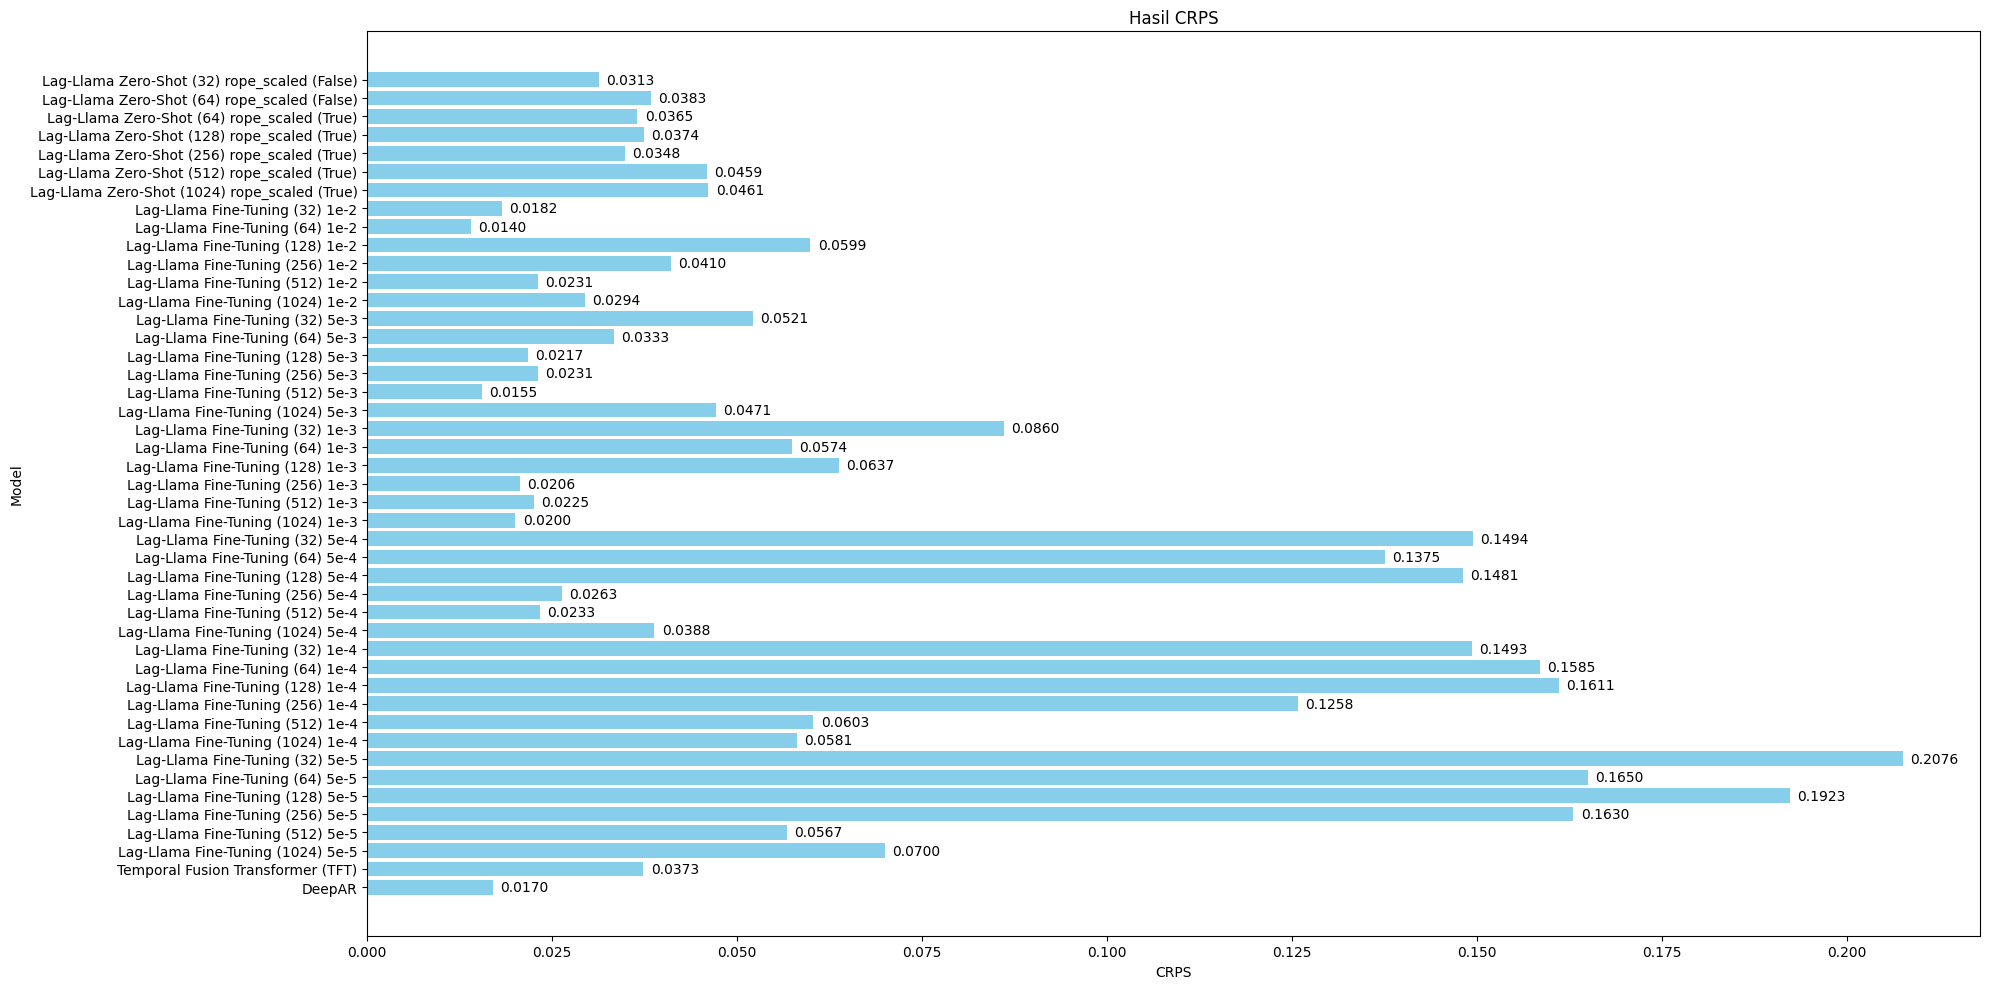

In [1]:
import matplotlib.pyplot as plt

def collect_crps_data(results):
    models, crps_values = [], []
    for model, data in results.items():
        if isinstance(data, dict):
            for sub_model, sub_data in data.items():
                for length, crps in sub_data.items():
                    models.append(f"{model} ({length}) {sub_model}")
                    crps_values.append(crps)
        else:
            models.append(model)
            crps_values.append(data)
    return models, crps_values

results = {
    "Lag-Llama Zero-Shot": {
        "Rope scaled (False)": {length: globals()[f'zero_shot_len_{length}_false'] for length in context_length[:2]},
        "Rope scaled (True)": {length: globals()[f'zero_shot_len_{length}_true'] for length in context_length[1:]}
    },
    "Lag-Llama Fine-Tuning": {
        lr: {length: globals()[f"fine_tuning_len_{length}_lr_{lr.replace('-', '_')}"] for length in context_length}
        for lr in learning_rates
    },
    "Temporal Fusion Transformer (TFT)": tft_agg_metrics['mean_wQuantileLoss'],
    "DeepAR": deepar_agg_metrics['mean_wQuantileLoss']
}

models, crps_values = collect_crps_data(results)
plt.figure(figsize=(32, 16))
bars = plt.barh(models, crps_values, color='skyblue')
plt.xlabel('CRPS')
plt.ylabel('Model')
plt.title('Hasil CRPS')
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{width:.4f}', va='center')

plt.tight_layout()
plt.show()

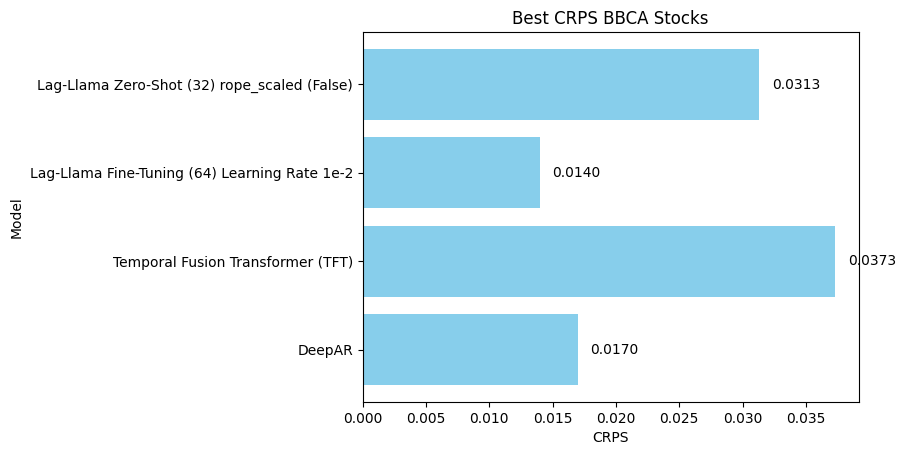

In [3]:
import matplotlib.pyplot as plt

data = {
    "Lag-Llama Zero-Shot (32) rope_scaled (False)": 0.0313,
    "Lag-Llama Fine-Tuning (64) Learning Rate 1e-2": 0.0140,
    "Temporal Fusion Transformer (TFT)": 0.0373,
    "DeepAR": 0.0170
}

models = list(data.keys())
crps_values = list(data.values())
fig, ax = plt.subplots()

bars = ax.barh(models, crps_values, color='skyblue')
plt.xlabel('CRPS')
plt.ylabel('Model')
plt.title('Best CRPS BBCA Stocks')
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height() / 2, f'{width:.4f}', va='center')

plt.show()